In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
N_up = 3
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *



In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
cuda = torch.cuda.is_available()

# Setup for MNIST

In [9]:
dname = 'MNIST'

In [10]:
def binarize_noise(x, std=0):
    if std != 0:
        noise = x.new(x.shape).normal_(mean=0, std=std)
        x = (x + noise)
    # BINARIZE MNIST
    x = x.clamp(0, 1)
    x = x.new(x.shape).bernoulli_(x)
    return x.data


## Load GT VAEAC



In [11]:
import torch
from torchvision import datasets, transforms
from VAEAC.MNISTconv_bern import VAEAC_bern_net
from VAEAC.train import train_VAEAC
from src.utils import Datafeed
from src.masks import top_masker



input_dim = 784
Nclass = 10
latent_dim = 20

batch_size = 128
nb_epochs = 600
early_stop = 60
lr = 3e-4

cuda = torch.cuda.is_available()

VAEAC = VAEAC_bern_net(input_dim+(10 if Nclass is not None else 0), latent_dim, lr=lr,
                     targets=(Nclass is not None), cuda=cuda)

masker = top_masker(p=1)

save_dir = '../../saves/resnet_class_VAEAC_20d_' + dname
VAEAC.load(save_dir + '_models/theta_best.dat')

##### Now under NET
import torch
from torchvision import datasets, transforms
from VAEAC.MNISTconv_bern import VAEAC_bern_net
from VAEAC.under_net import under_VAEAC
from VAE.train import train_VAE

base_network = VAEAC.model
width = 150
depth = 2
latent_dim = 8

batch_size = 128
nb_epochs = 800
lr = 3e-4

cuda = torch.cuda.is_available()

under_VAEAC = under_VAEAC(base_network, width, depth, latent_dim, lr, cuda=cuda)

save_dir = '../../saves/fc_VAEAC_208d_under_resnet_' + dname
under_VAEAC.load(save_dir + '_models/theta_best.dat')




Net:
VAE_bern_net
    Total params: 2.71M
Reading ../../saves/resnet_class_VAEAC_20d_MNIST_models/theta_best.dat



/homes/ja666/anaconda2/lib/python2.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'VAEAC.MNISTconv_bern.MNIST_VAEAC_bern' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/homes/ja666/anaconda2/lib/python2.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/homes/ja666/anaconda2/lib/python2.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by acces

  restoring epoch: 224, lr: 0.000300

Net:
VAE_gauss_net
    Total params: 0.06M
Reading ../../saves/fc_VAEAC_208d_under_resnet_MNIST_models/theta_best.dat

  restoring epoch: 342, lr: 0.000300


/homes/ja666/anaconda2/lib/python2.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'VAE.fc_gauss.VAE_gauss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/homes/ja666/anaconda2/lib/python2.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/homes/ja666/anaconda2/lib/python2.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.loss.MSELoss' has changed. you can retrieve the original source code by accessing the object's so

342

In [ ]:
from __future__ import division
from interpret.generate_data import sample_artificial_dataset, sample_artificial_targets_bern
from src.utils import MNIST_mean_std_norm
from torchvision.utils import save_image, make_grid

Npoints = 55000
Ntrain = 50000

u_dims = 8 # has to be inclusing y

test_dims = list(range(784, 794))
print('test dims', test_dims)

batch_size = 500

nsm = 0
x_art_stack = []
y_art_stack = []
y_art_cond_stack = []
xy_art_stack = []
for ns in np.arange(batch_size, Npoints+batch_size, batch_size):
    x_art, y_art, xy_art = sample_artificial_dataset(under_VAEAC, test_dims, (ns-nsm), u_dims,
                                                     sig=False, bern=True, softmax=True)
    
    y_art_cond = sample_artificial_targets_bern(VAEAC, xy_art, test_dims, N_target_samples=1, z_mean=False).data
    y_art_cond_stack.append(y_art_cond[0])
    
    x_art_stack.append(x_art.data)
    y_art_stack.append(y_art.data)
    xy_art_stack.append(xy_art.data)
    nsm = ns
    
x_art = torch.cat(x_art_stack, dim=0)
y_art = torch.cat(y_art_stack, dim=0)
y_art = y_art.max(dim=1)[1]
y_art_cond = torch.cat(y_art_cond_stack, dim=0)
y_art_cond = y_art_cond.max(dim=1)[1]
xy_art = torch.cat(xy_art_stack, dim=0)



# Get conditional targets #########
vaeac_err = (y_art != y_art_cond).long().sum().item()/y_art.shape[0]
print(vaeac_err)
#################


xy_art_train = xy_art[:Ntrain, :]
xy_art_test = xy_art[Ntrain:, :]


x_art_train = x_art[:Ntrain]
x_art_train = x_art_train.view(x_art_train.shape[0], 1, 28, 28).cpu().numpy()
x_art_test = x_art[Ntrain:]
x_art_test = x_art_test.view(x_art_test.shape[0], 1, 28, 28).cpu().numpy()

y_art_train = y_art_cond[:Ntrain].cpu().numpy()
y_art_test = y_art_cond[Ntrain:].cpu().numpy()

art_xy_trainset = Datafeed(x_art_train, y_art_train, transform=None)
art_xy_valset = Datafeed(x_art_test, y_art_test, transform=None)

art_x_trainset = Datafeed(x_art_train, x_art_train, transform=None)
art_x_valset = Datafeed(x_art_test, x_art_test, transform=None)

art_xy_trainset_BNN = Datafeed(MNIST_mean_std_norm(x_art_train), y_art_train, transform=None)
art_xy_valset_BNN = Datafeed(MNIST_mean_std_norm(x_art_test), y_art_test, transform=None)

print(x_art_train.shape)
print(y_art_test.shape)

plt.figure(dpi=100)
dd = make_grid(x_art[:64,:].view(64, 1, 28, 28).cpu(), nrow=8).numpy()
fig = plt.imshow(np.transpose(dd, (1,2,0)), interpolation='nearest')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()
print(y_art[:64])
print(y_art_cond[:64])

('test dims', [784, 785, 786, 787, 788, 789, 790, 791, 792, 793])


# Train models

We recommend using pretrained models for faster results


In [ ]:
use_pretrained_ART = True

## Train BNN



In [ ]:
%matplotlib inline
import torch
from torchvision import datasets, transforms
from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

dname = 'MNIST'
save_dir = '../../saves/fc_BNN_NEW_ART_' + dname


input_dim = 784
width = 1000
depth = 2
output_dim = 10
model = MLP(input_dim, width, depth, output_dim, flatten_image=False)

N_train = len(art_xy_trainset_BNN)
batch_size = 512#
nb_epochs = 575 # We can do less iterations as this method has faster convergence

lr = 1e-2

## weight saving parameters #######
burn_in = 15 # this is in epochs 
sim_steps = 4 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 150

resample_its = 10
resample_prior_its = 45
re_burn = 1e7

cuda = torch.cuda.is_available()
art_BNN = BNN_cat(model, N_train, lr=lr, cuda=cuda)

if not use_pretrained_ART:
    cost_train, cost_dev, err_train, err_dev = train_BNN_classification(art_BNN, save_dir, batch_size,
                             nb_epochs, art_xy_trainset_BNN, art_xy_valset_BNN, cuda,
                             burn_in, sim_steps, N_saves, resample_its, resample_prior_its,
                             re_burn, flat_ims=True)

art_BNN.load_weights(save_dir + '_models/state_dicts.pkl')
    
# print(len(art_BNN.weight_set_samples))
    

## Train VAE

Had low stop iteration for compas dataset: running again -> seems to be all that it needs 

ALso stop at 19 for LSAT

In [ ]:
%matplotlib inline
import torch
from torchvision import datasets, transforms
from VAE.MNISTconv_bern import MNISTconv_VAE_bern_net
from VAE.train import train_VAE
from VAE.models import MNIST_generator_resnet, MNIST_recognition_resnet




latent_dim = 10

batch_size = 64
nb_epochs = 300
lr = 7e-4
early_stop = 60

cuda = torch.cuda.is_available()

encoder = MNIST_recognition_resnet(latent_dim)
decoder = MNIST_generator_resnet(latent_dim)

VAE_art = MNISTconv_VAE_bern_net(latent_dim, encoder, decoder, lr, cuda=cuda)

save_dir = '../../saves/resnet_VAE_NEW_ART_' + dname

if not use_pretrained_ART:
    vlb_train, vlb_dev = train_VAE(VAE_art, save_dir, batch_size, nb_epochs, art_x_trainset, art_x_valset,
                                   cuda=cuda, flat_ims=False, train_plot=True, early_stop=early_stop)

VAE_art.load(save_dir+'_models/theta_best.dat')



## Train VAEAC noclass 

In [ ]:
from VAEAC.MNISTconv_bern import VAEAC_bern_net
from VAEAC.train import train_VAEAC
from src.utils import Datafeed
from src.masks import top_masker


input_dim = 784
Nclass = None
latent_dim = 20

batch_size = 128
nb_epochs = 600
early_stop = 60
lr = 3e-4

cuda = torch.cuda.is_available()

VAEAC_art = VAEAC_bern_net(input_dim+(10 if Nclass is not None else 0), latent_dim, lr=lr,
                     targets=(Nclass is not None), cuda=cuda)

masker = top_masker(p=1)

save_dir = '../../saves/resnet_VAEAC_NEW_ART_' + dname

if not use_pretrained_ART:
    vlb_train, vlb_dev = train_VAEAC(VAEAC_art, masker, save_dir, batch_size, nb_epochs, art_x_trainset, art_x_valset, cuda,
                flat_ims=True, train_plot=True, Nclass=Nclass, early_stop=early_stop)

VAEAC_art.load(save_dir+'_models/theta_best.dat')


# Run experiments

In [ ]:
from src.utils import mkdir
experiment_dir = '../../experiment_data/NEW_art_' + dname + '/'
print(experiment_dir)
mkdir(experiment_dir)

Text(0.5,1,'epistemic')

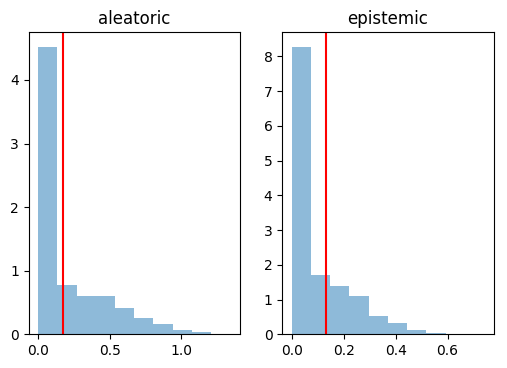

In [12]:



art_a_thresh = 0.17
art_e_thresh = 0.13

from interpret.functionally_grounded import get_BNN_uncertainties

total_stack, aleatoric_stack, epistemic_stack  = get_BNN_uncertainties(art_BNN, torch.from_numpy(x_art_test),
                                           regression=False, batch_size=512,
                                           norm_MNIST=True, flatten=True, return_probs=False, prob_BNN=True)


aleatoric_idxs = aleatoric_stack.cpu().numpy()>=art_a_thresh
epistemic_idxs = epistemic_stack.cpu().numpy()>=art_e_thresh

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100)
ax[0].hist(aleatoric_stack.cpu().numpy(), alpha=0.5, density=True)
ax[0].axvline(art_a_thresh, c='r')
ax[0].set_title('aleatoric')
ax[1].hist(epistemic_stack.cpu().numpy(), alpha=0.5, density=True)
ax[1].axvline(art_e_thresh, c='r')
ax[1].set_title('epistemic')

## Get Raw GT VAEAC + BNN baselines

#### Might be worth defining thresholds for things we are going to explain but I dont really want to because I would need to base myself on the models trained right now. Averages might be fine.

### VAEAC Aleatoric of orignal data

In [13]:
test_dims

[784, 785, 786, 787, 788, 789, 790, 791, 792, 793]

In [14]:
from interpret.functionally_grounded import get_BNN_uncertainties, evaluate_aleatoric_explanation_MNIST


OG_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_MNIST(VAEAC, torch.Tensor(x_art_test[aleatoric_idxs]), test_dims,
                                                          N_target_samples=100, batch_size=512)

print(OG_VAEAC_aleatoric_uncert.shape)
# np.save(experiment_dir+'baseline_BNN_aleatoric_std.npy', OG_BNN_aleatoric_std.data.cpu().numpy())
print('baseline BNN aleatoric uncert', aleatoric_stack.data.cpu().numpy()[aleatoric_idxs].mean(axis=0))


print('test GT marginal shape', OG_VAEAC_aleatoric_uncert.shape)
print('test GT mean uncert (aleatoric)', OG_VAEAC_aleatoric_uncert.mean())



torch.Size([1791])
('baseline BNN aleatoric uncert', 0.48075378)
('test GT marginal shape', torch.Size([1791]))
('test GT mean uncert (aleatoric)', tensor(0.3949))


### BNN error (epistemic) on original data


In [15]:
from interpret.functionally_grounded import evaluate_epistemic_explanation_MNIST


GT_test_err, GT_loglike_vec = \
    evaluate_epistemic_explanation_MNIST(art_BNN, VAEAC, torch.Tensor(x_art_test[epistemic_idxs]).cuda(),
                                                     test_dims=test_dims, outer_batch_size=512,
                                                     inner_batch_size=1024, VAEAC_samples=100)


print('baseline mean BNN epistemic', epistemic_stack.data.cpu().numpy()[epistemic_idxs].mean())

print('baseline mean BNN error', GT_test_err)
print('baseline mean BNN loglike', GT_loglike_vec.mean())



('baseline mean BNN epistemic', 0.2549398)
('baseline mean BNN error', 0.18271257905832747)
('baseline mean BNN loglike', -0.542206)


### VAEAC loglike

In [16]:
torch.cuda.empty_cache()

In [17]:
from interpret.functionally_grounded import get_VAEAC_px, get_VAEAC_px_gauss_cat


# This works for MNIST images because of automatic flattening done inside the VAEAC resnet model

x_to_log_px = binarize_noise(torch.from_numpy(x_art_test[aleatoric_idxs]), std=0).view(x_art_test[aleatoric_idxs].shape[0], -1)

log_px_vaeac_a = get_VAEAC_px(under_VAEAC, x_to_log_px, y_dims=test_dims,
                            Nsamples=500, bern=True, batch_size=1024).data.cpu().numpy()

# log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

print('aleatoric baseline log_px [mean, std]', log_px_vaeac_a.mean(), log_px_vaeac_a.std())

x_to_log_px = binarize_noise(torch.from_numpy(x_art_test[epistemic_idxs]), std=0).view(x_art_test[epistemic_idxs].shape[0], -1)

log_px_vaeac_e = get_VAEAC_px(under_VAEAC, x_to_log_px, y_dims=test_dims,
                            Nsamples=500, bern=True, batch_size=1024).data.cpu().numpy()

# log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

print('aleatoric baseline log_px [mean, std]', log_px_vaeac_e.mean(), log_px_vaeac_e.std())


('aleatoric baseline log_px [mean, std]', -87.44371, 19.935198)
('aleatoric baseline log_px [mean, std]', -89.89217, 19.692263)


## input Sensitivity

In [18]:
sensitivity_steps = np.logspace(np.log(0.001), np.log(200), 30, base=np.e)


### Aleatoric Sensitivity RUN

In [19]:
from interpret.explanation_tools import input_uncertainty_step_gauss, input_uncertainty_step_cat
from interpret.CLUE import CLUE
from src.utils import Ln_distance
from src.probability import decompose_std_gauss, decompose_entropy_cat

sense_aleatoric_delta_H_vec = []
sense_aleatoric_delta_X_vec = []
sense_aleatoric_logpx_vec = []
for step in sensitivity_steps:
    
    # step = 1
    aleatoric_coeff=1
    epistemic_coeff=0

    sens_x_aleatoric = input_uncertainty_step_cat(art_BNN, art_xy_valset, aleatoric_coeff=aleatoric_coeff,
                                        epistemic_coeff=epistemic_coeff, stepsize_perdim=-step,
                             batch_size=512, cuda=True, norm_MNIST=(dname=='MNIST'), flatten=True, norm_grad=False)

    sens_x_aleatoric = sens_x_aleatoric.data.cpu().numpy()[aleatoric_idxs]
    
    ###########################################################################################
    
    
    from interpret.functionally_grounded import get_BNN_uncertainties, evaluate_aleatoric_explanation_cat, evaluate_aleatoric_explanation_gauss

    total_uncert_BNN_sens_aleatoric, aleatoric_uncert_BNN_sens_aleatoric, epistemic_uncert_BNN_sens_aleatoric\
            = get_BNN_uncertainties(art_BNN, torch.from_numpy(sens_x_aleatoric),
                                       regression=False, batch_size=512,
                                       norm_MNIST=True, flatten=True, return_probs=False, prob_BNN=True)



    sens_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_MNIST(VAEAC, torch.Tensor(sens_x_aleatoric),
                                                                     test_dims,
                                                              N_target_samples=100, batch_size=512)






    print(sens_VAEAC_aleatoric_uncert.shape)
    # np.save(experiment_dir+'baseline_BNN_aleatoric_std.npy', OG_BNN_aleatoric_std.data.cpu().numpy())
    print('sens_aleatoric BNN aleatoric uncert', aleatoric_stack.data.cpu().numpy()[aleatoric_idxs].mean(axis=0),
          aleatoric_uncert_BNN_sens_aleatoric.data.cpu().numpy().mean(axis=0))


    print('test sens_aleatoric marginal shape', sens_VAEAC_aleatoric_uncert.shape)
    print('test sens_aleatoric mean uncert (aleatoric)',  OG_VAEAC_aleatoric_uncert.mean(), sens_VAEAC_aleatoric_uncert.mean())


    sens_aleatoric_deltax = np.abs(x_art_test[aleatoric_idxs] - sens_x_aleatoric).sum(axis=(1,2,3))
    sens_aleatoric_deltaH = (OG_VAEAC_aleatoric_uncert - sens_VAEAC_aleatoric_uncert).cpu().numpy()
    sens_aleatoric_fm = (OG_VAEAC_aleatoric_uncert - sens_VAEAC_aleatoric_uncert).cpu().numpy() / (sens_aleatoric_deltax + 1e-6)
    print('test sens_aleatoric fm mean std (aleatoric)', np.nanmean(sens_aleatoric_fm), np.nanstd(sens_aleatoric_fm))

    
    ###########################################################################################
    
    from interpret.functionally_grounded import get_VAEAC_px, get_VAEAC_px_gauss_cat


    x_to_log_px = binarize_noise(torch.from_numpy(sens_x_aleatoric), std=0).view(sens_x_aleatoric.shape[0], -1)
    log_px_vaeac_sens_aleatoric = get_VAEAC_px(under_VAEAC, x_to_log_px,
                                               y_dims=test_dims, Nsamples=500, bern=True, batch_size=1250).data.cpu().numpy()

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('sens_aleatoric log_px [mean, std]', log_px_vaeac_a.mean(), log_px_vaeac_sens_aleatoric.mean(), log_px_vaeac_sens_aleatoric.std())
    
    sense_aleatoric_delta_H_vec.append(sens_aleatoric_deltaH)
    sense_aleatoric_delta_X_vec.append(sens_aleatoric_deltax)
    sense_aleatoric_logpx_vec.append(log_px_vaeac_sens_aleatoric)
    
sense_aleatoric_delta_H_vec = np.stack(sense_aleatoric_delta_H_vec, axis=0)
sense_aleatoric_delta_X_vec = np.stack(sense_aleatoric_delta_X_vec, axis=0)
sense_aleatoric_logpx_vec = np.stack(sense_aleatoric_logpx_vec, axis=0)
    

torch.Size([1791])
('sens_aleatoric BNN aleatoric uncert', 0.48075378, 0.4803295)
('test sens_aleatoric marginal shape', torch.Size([1791]))
('test sens_aleatoric mean uncert (aleatoric)', tensor(0.3949), tensor(0.3957))
('test sens_aleatoric fm mean std (aleatoric)', 0.011456147, 2.2145271)
('sens_aleatoric log_px [mean, std]', -87.44371, -88.38249, 20.051023)
torch.Size([1791])
('sens_aleatoric BNN aleatoric uncert', 0.48075378, 0.479481)
('test sens_aleatoric marginal shape', torch.Size([1791]))
('test sens_aleatoric mean uncert (aleatoric)', tensor(0.3949), tensor(0.3952))
('test sens_aleatoric fm mean std (aleatoric)', 0.010939442, 0.7513529)
('sens_aleatoric log_px [mean, std]', -87.44371, -87.936844, 19.7246)
torch.Size([1791])
('sens_aleatoric BNN aleatoric uncert', 0.48075378, 0.4786328)
('test sens_aleatoric marginal shape', torch.Size([1791]))
('test sens_aleatoric mean uncert (aleatoric)', tensor(0.3949), tensor(0.3955))
('test sens_aleatoric fm mean std (aleatoric)', 0.000

('sens_aleatoric log_px [mean, std]', -87.44371, -2834.7021, 417.27274)
torch.Size([1791])
('sens_aleatoric BNN aleatoric uncert', 0.48075378, 0.012253656)
('test sens_aleatoric marginal shape', torch.Size([1791]))
('test sens_aleatoric mean uncert (aleatoric)', tensor(0.3949), tensor(0.0817))
('test sens_aleatoric fm mean std (aleatoric)', 0.000114787275, 0.00015414674)
('sens_aleatoric log_px [mean, std]', -87.44371, -2956.877, 408.13803)
torch.Size([1791])
('sens_aleatoric BNN aleatoric uncert', 0.48075378, 0.009202821)
('test sens_aleatoric marginal shape', torch.Size([1791]))
('test sens_aleatoric mean uncert (aleatoric)', tensor(0.3949), tensor(0.0914))
('test sens_aleatoric fm mean std (aleatoric)', 8.358003e-05, 0.00011644127)
('sens_aleatoric log_px [mean, std]', -87.44371, -3017.5388, 404.45828)


### Epistemic Sensitivity RUN

In [20]:
from interpret.explanation_tools import input_uncertainty_step_gauss, input_uncertainty_step_cat
from interpret.CLUE import CLUE
from src.utils import Ln_distance
from src.probability import decompose_std_gauss, decompose_entropy_cat


sense_epistemic_delta_err_vec = []
sense_epistemic_delta_X_vec = []
sense_epistemic_logpx_vec = []

for step in sensitivity_steps:

    aleatoric_coeff=0
    epistemic_coeff=1


    sens_x_epistemic = input_uncertainty_step_cat(art_BNN, art_xy_valset, aleatoric_coeff=aleatoric_coeff,
                                        epistemic_coeff=epistemic_coeff, stepsize_perdim=-step,
                             batch_size=512, cuda=True, norm_MNIST=(dname=='MNIST'), flatten=True, norm_grad=False)

    sens_x_epistemic = sens_x_epistemic.data.cpu().numpy()[epistemic_idxs]

    ###########################################################################################
    
    from interpret.functionally_grounded import evaluate_epistemic_explanation_cat, evaluate_epistemic_explanation_gauss

    total_uncert_BNN_sens_epistemic, aleatoric_uncert_BNN_sens_epistemic, epistemic_uncert_BNN_sens_epistemic\
            = get_BNN_uncertainties(art_BNN, torch.from_numpy(sens_x_epistemic),
                                       regression=False, batch_size=512,
                                       norm_MNIST=True, flatten=True, return_probs=False, prob_BNN=True)

    sens_test_err, sens_loglike_vec = evaluate_epistemic_explanation_MNIST(art_BNN, VAEAC,
                                                         torch.Tensor(sens_x_epistemic).cuda(),
                                                         test_dims=test_dims, outer_batch_size=256,
                                                         inner_batch_size=512, VAEAC_samples=100)

    print('sens_epistemic mean BNN epistemic', epistemic_stack.data.cpu().numpy()[epistemic_idxs].mean(), epistemic_uncert_BNN_sens_epistemic.mean())

    print('sens_epistemic mean BNN error', GT_test_err, sens_test_err)
    print('sens_epistemic mean BNN loglike', sens_loglike_vec.mean())


    sens_epistemic_deltax = np.abs(x_art_test[epistemic_idxs] - sens_x_epistemic).sum(axis=(1,2,3))
    sens_epistemic_fm = (GT_test_err - sens_test_err) / (sens_epistemic_deltax + 1e-6)
    print('test sens_epistemic fm mean std (epistemic)', np.nanmean(sens_epistemic_fm), np.nanstd(sens_epistemic_fm))

    ###########################################################################################
    
    x_to_log_px = binarize_noise(torch.from_numpy(sens_x_epistemic), std=0).view(sens_x_epistemic.shape[0], -1)
    log_px_vaeac_sens_epistemic = get_VAEAC_px(under_VAEAC, x_to_log_px, y_dims=test_dims,
                                               Nsamples=500, bern=True, batch_size=1250).data.cpu().numpy()

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('sens epistemic log_px [mean, std]', log_px_vaeac_e.mean(), log_px_vaeac_sens_epistemic.mean(), log_px_vaeac_sens_epistemic.std())

    sense_epistemic_delta_err_vec.append((GT_test_err - sens_test_err))
    sense_epistemic_delta_X_vec.append(sens_epistemic_deltax)
    sense_epistemic_logpx_vec.append(log_px_vaeac_sens_epistemic)
    
sense_epistemic_delta_err_vec = np.stack(sense_epistemic_delta_err_vec, axis=0)
sense_epistemic_delta_X_vec = np.stack(sense_epistemic_delta_X_vec, axis=0)
sense_epistemic_logpx_vec = np.stack(sense_epistemic_logpx_vec, axis=0)


('sens_epistemic mean BNN epistemic', 0.2549398, tensor(0.2549, device='cuda:0'))
('sens_epistemic mean BNN error', 0.18271257905832747, 0.1770906535488405)
('sens_epistemic mean BNN loglike', -0.5402342)
('test sens_epistemic fm mean std (epistemic)', 0.5339398, 0.18789755)
('sens epistemic log_px [mean, std]', -89.89217, -90.222855, 19.69425)
('sens_epistemic mean BNN epistemic', 0.2549398, tensor(0.2547, device='cuda:0'))
('sens_epistemic mean BNN error', 0.18271257905832747, 0.18271257905832747)
('sens_epistemic mean BNN loglike', -0.54433197)
('test sens_epistemic fm mean std (epistemic)', 0.0, 0.0)
('sens epistemic log_px [mean, std]', -89.89217, -89.71925, 19.088951)
('sens_epistemic mean BNN epistemic', 0.2549398, tensor(0.2545, device='cuda:0'))
('sens_epistemic mean BNN error', 0.18271257905832747, 0.18060435699226984)
('sens_epistemic mean BNN loglike', -0.5401855)
('test sens_epistemic fm mean std (epistemic)', 0.04004889, 0.014094911)
('sens epistemic log_px [mean, std]', 

('sens epistemic log_px [mean, std]', -89.89217, -2736.121, 375.8876)
('sens_epistemic mean BNN epistemic', 0.2549398, tensor(1.1346, device='cuda:0'))
('sens_epistemic mean BNN error', 0.18271257905832747, 0.7962052002810963)
('sens_epistemic mean BNN loglike', -inf)
('test sens_epistemic fm mean std (epistemic)', -0.0002913619, 0.000102545346)
('sens epistemic log_px [mean, std]', -89.89217, -2843.4307, 364.3733)


## CLUE

In [24]:
import numpy as np
from interpret.visualization_tools import latent_map_2d_gauss, latent_project_gauss, latent_project_cat, latent_project_MNIST


_, _, z_test, x_test, _ = \
    latent_project_MNIST(art_BNN, VAE_art, dset=art_xy_valset, batch_size=256, cuda=cuda, flatten_BNN=True, flatten_VAE=False)


z_init_batch_a = z_test[aleatoric_idxs]
x_init_batch_a = x_test[aleatoric_idxs]

z_init_batch_e = z_test[epistemic_idxs]
x_init_batch_e = x_test[epistemic_idxs]

CLUE_lr_a = 0.1
CLUE_lr_e = 0.1
CLUE_lambdas = np.logspace(np.log(0.01), np.log(1000), 30, base=np.e)



### Run Aleatoric CLUE

it 34, all conditions met, stopping
torch.Size([1732])
('CLUE_aleatoric BNN aleatoric uncert', 0.48261982, 0.012008159)
('test CLUE_aleatoric marginal shape', torch.Size([1732]))
('test CLUE_aleatoric mean uncert (aleatoric)', tensor(0.3941), tensor(0.0024))
('test sCLUE aleatoric fm mean std (aleatoric)', 0.0080765905, 0.0075687063)
('CLUE_aleatoric log_px [mean, std]', -88.09398, -91.73805, 19.857235)
it 34, all conditions met, stopping
torch.Size([1732])
('CLUE_aleatoric BNN aleatoric uncert', 0.48261982, 0.014570622)
('test CLUE_aleatoric marginal shape', torch.Size([1732]))
('test CLUE_aleatoric mean uncert (aleatoric)', tensor(0.3941), tensor(0.0024))
('test sCLUE aleatoric fm mean std (aleatoric)', 0.008770164, 0.0079996055)
('CLUE_aleatoric log_px [mean, std]', -88.09398, -92.40658, 20.14964)
torch.Size([1732])
('CLUE_aleatoric BNN aleatoric uncert', 0.48261982, 0.016386092)
('test CLUE_aleatoric marginal shape', torch.Size([1732]))
('test CLUE_aleatoric mean uncert (aleatoric)

('CLUE_aleatoric log_px [mean, std]', -88.09398, -98.25698, 21.894285)
it 28, all conditions met, stopping
it 29, all conditions met, stopping
it 30, all conditions met, stopping
it 31, all conditions met, stopping
it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
it 25, all conditions met, stopping
it 26, all conditions met, stopping
it 27, all conditions met, stopping
it 28, all conditions met, stopping
it 29, all conditions met, stopping
it 30, all conditions met, stopping
it 31, all conditions met, stopping
it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
torch.Size([1732])
('CLUE_aleatoric BNN aleatoric uncert', 0.48261982, 0.45799908)
('test CLUE_aleatoric marginal shape', torch.Size([1732]))
('test CLUE_aleatoric mean uncert (aleatoric)', tensor(0.3941), tensor(0.3780))
('test sCLUE aleatoric fm mean std (aleatoric)', 0.001414835, 0.018064775)
('CLUE_aleatoric log

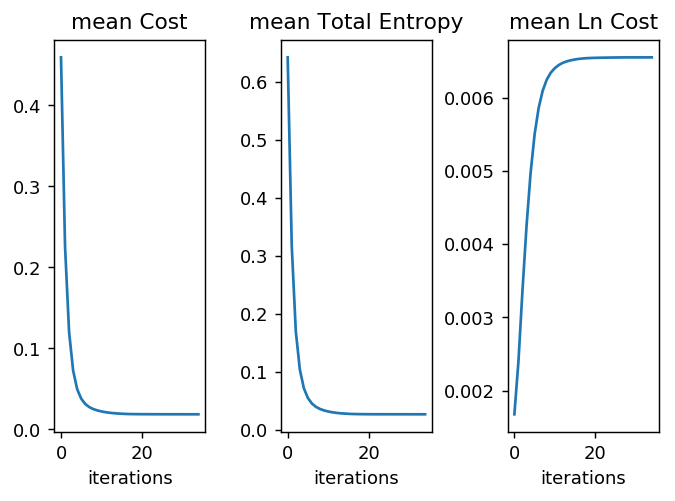

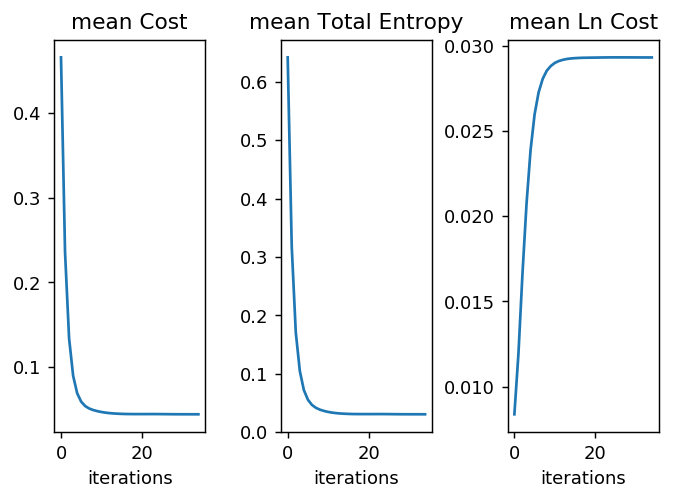

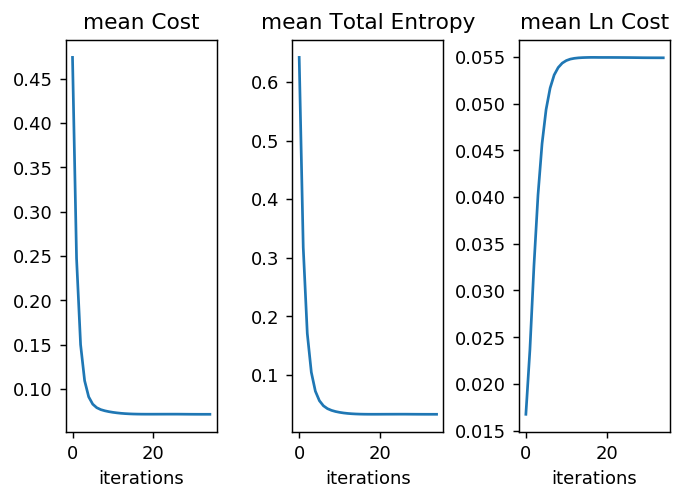

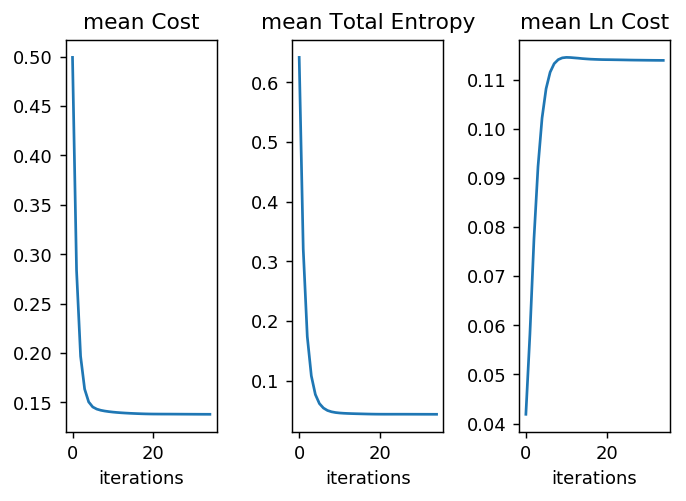

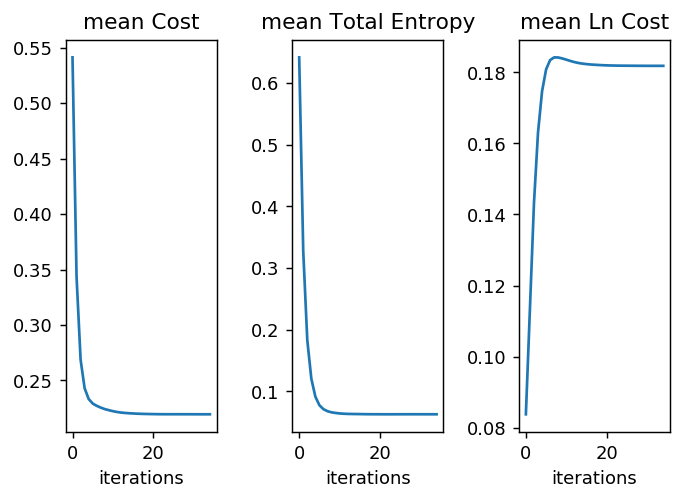

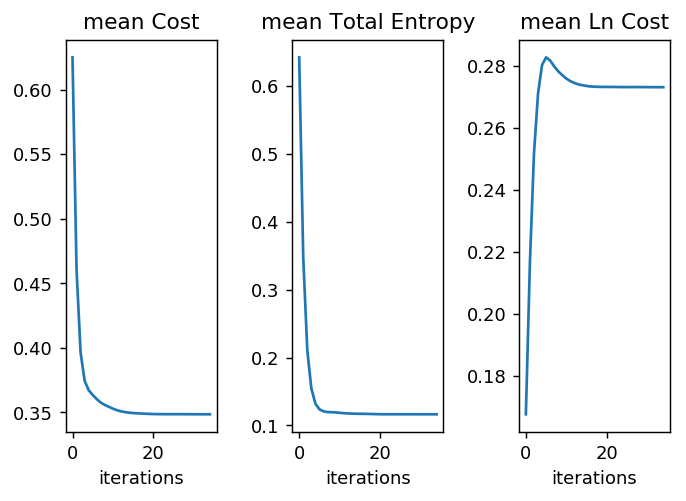

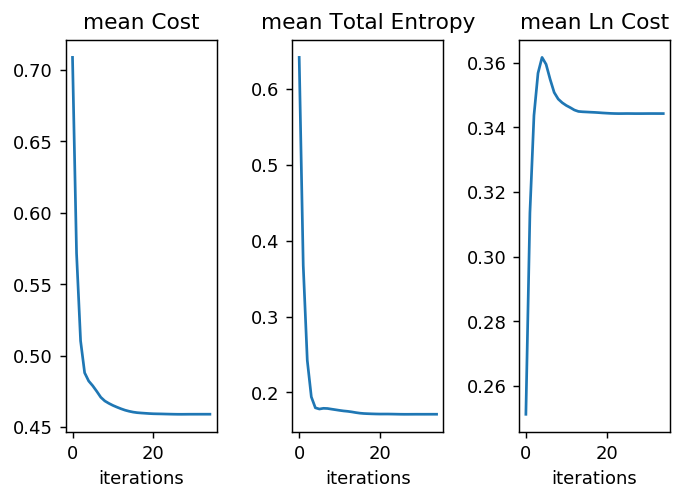

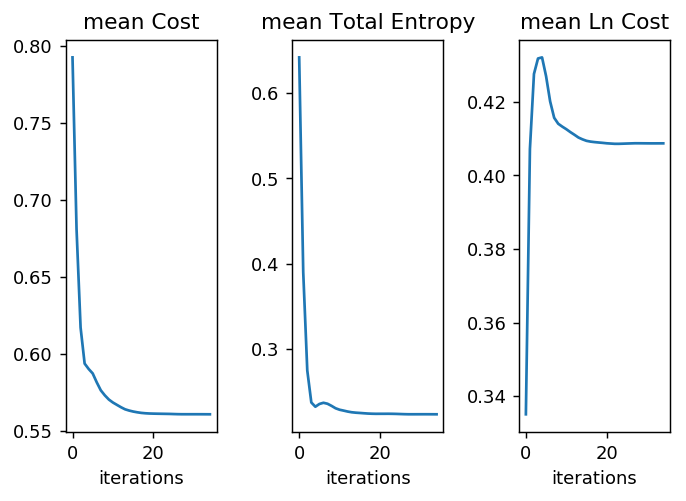

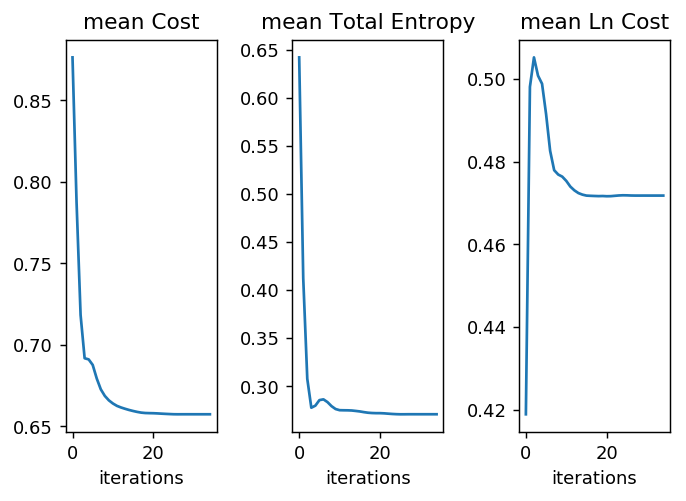

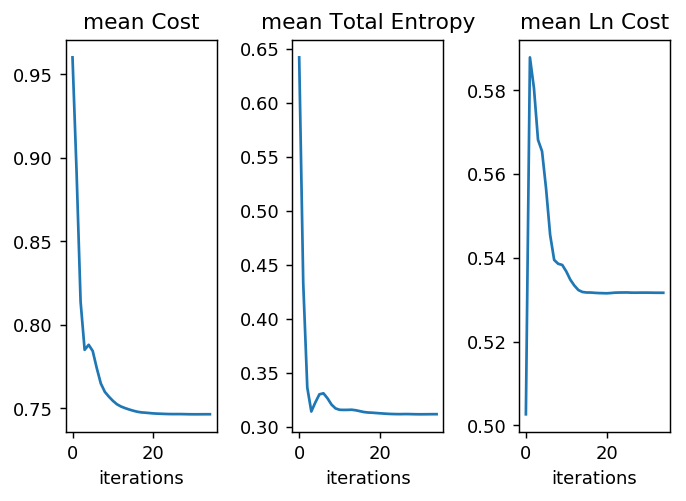

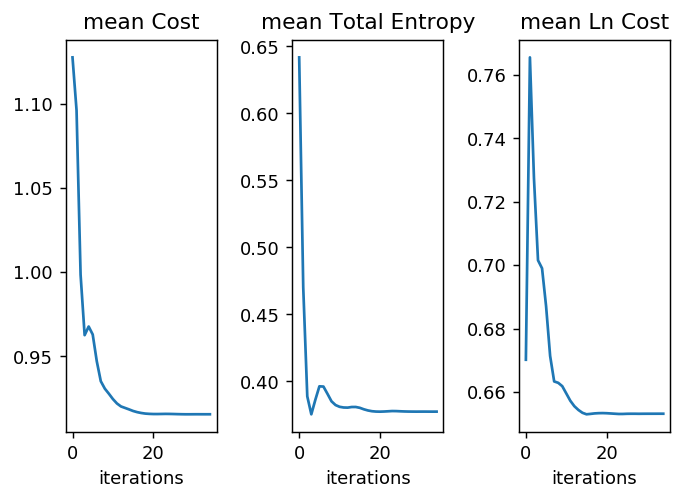

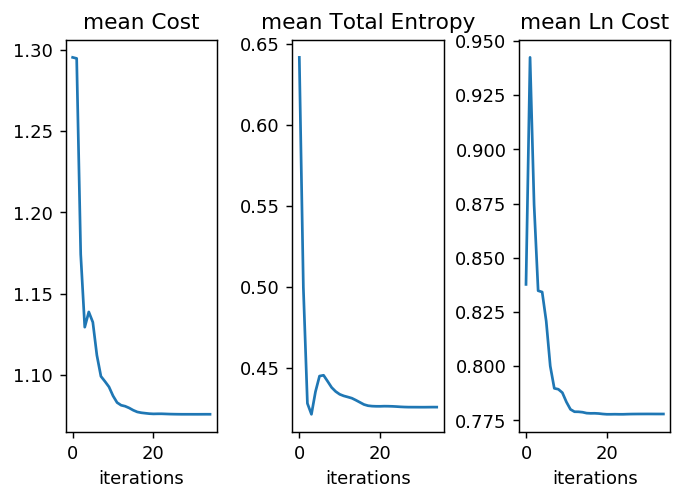

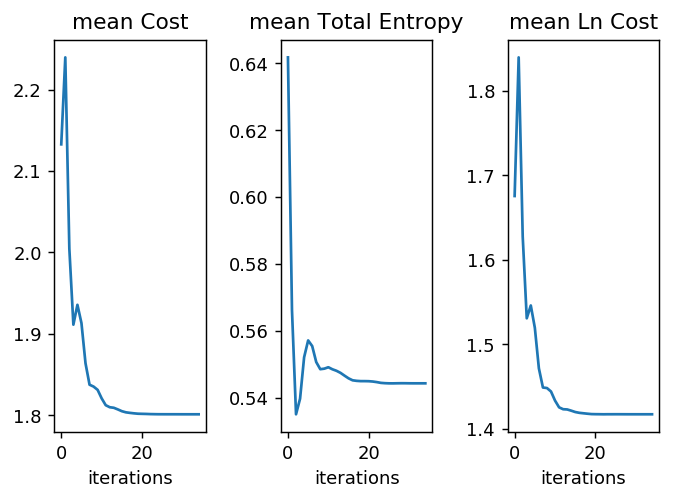

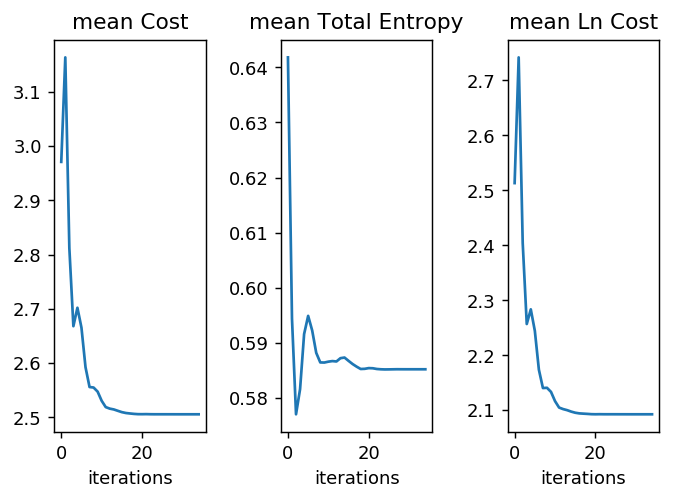

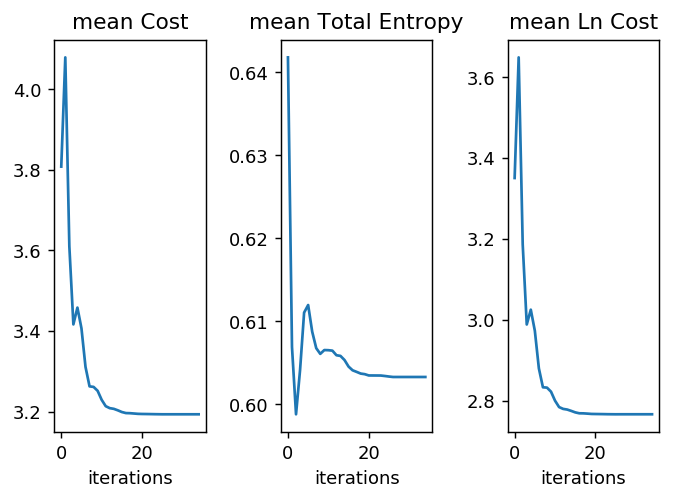

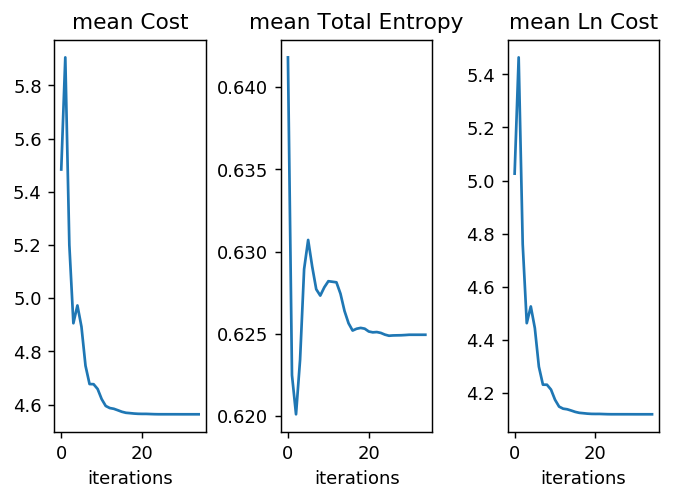

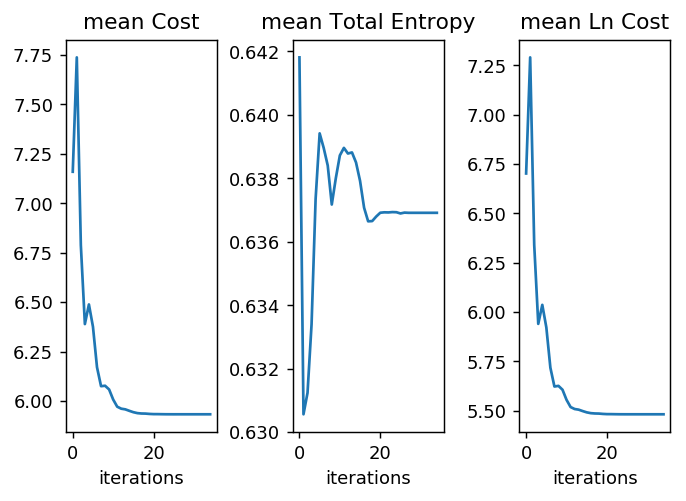

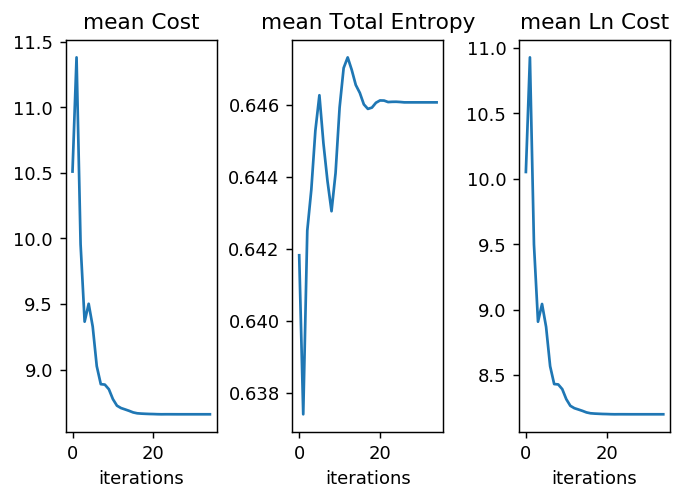

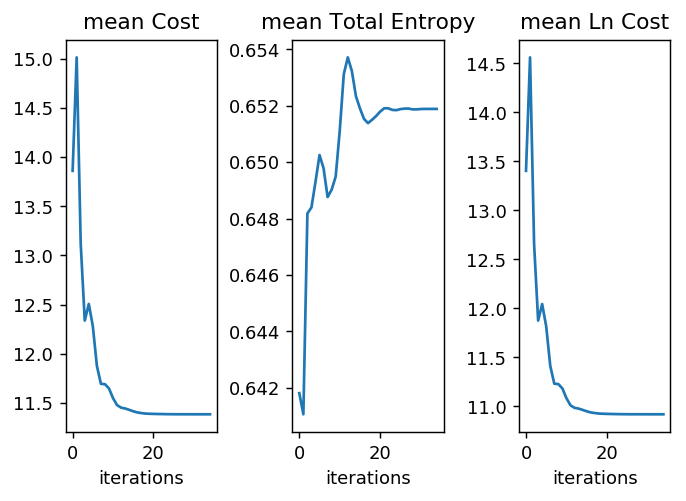

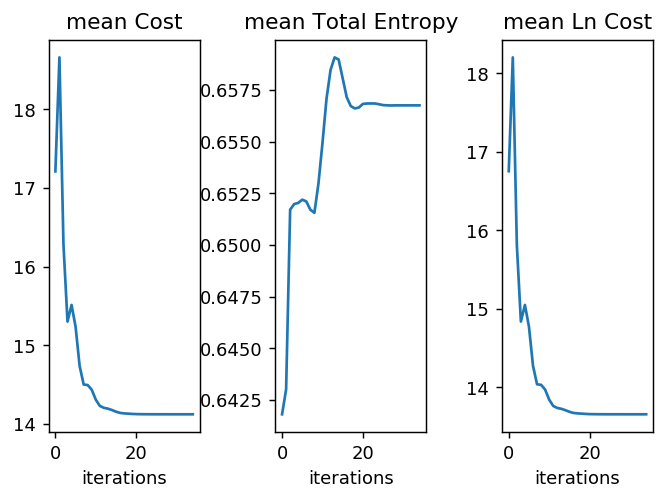

In [25]:
from interpret.CLUE import CLUE
from src.utils import Ln_distance
from src.probability import decompose_std_gauss, decompose_entropy_cat

batch_size = 1024

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch_a.reshape(x_init_batch_a.shape[0], -1).shape[1]

CLUE_aleatoric_delta_H_vec = []
CLUE_aleatoric_delta_X_vec = []
CLUE_aleatoric_logpx_vec = []

for distance_weight in (CLUE_lambdas / x_dim):

    # distance_weight = 15 / x_dim
    prediction_similarity_weight = 0

    lr = CLUE_lr_a

    aleatoric_weight = 1
    epistemic_weight = 0
    uncertainty_weight = 0


    torch.autograd.set_detect_anomaly(False)

    x_vec, z_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec = \
    CLUE.batch_optimise(VAE_art, art_BNN, x_init_batch_a, uncertainty_weight=uncertainty_weight, aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,
                          prior_weight=0, distance_weight=distance_weight, desired_preds=None,
                     latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,
                     lr=lr,  cond_mask=None, distance_metric=dist, z_init=z_init_batch_a, norm_MNIST=True,
                          flatten_BNN=True,
                     regression=False, cuda=True, batch_size=batch_size, min_steps=3, max_steps=35, n_early_stop=3)



    fig, axes = plt.subplots(1, 3, dpi=130)
    axes[0].plot(cost_vec.mean(axis=1))
    axes[0].set_title('mean Cost')
    axes[0].set_xlabel('iterations')

    axes[1].plot(uncertainty_vec.mean(axis=1))
    axes[1].set_title('mean Total Entropy')
    axes[1].set_xlabel('iterations')

    axes[2].plot(dist_vec.mean(axis=1))
    axes[2].set_title('mean Ln Cost')
    axes[2].set_xlabel('iterations')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    x_CLUE_aleatoric = x_vec[-1]
    
    #######################################################
    
    from interpret.functionally_grounded import get_BNN_uncertainties, evaluate_aleatoric_explanation_MNIST

    total_uncert_BNN_CLUE_aleatoric, aleatoric_uncert_BNN_CLUE_aleatoric, epistemic_uncert_BNN_CLUE_aleatoric\
            = get_BNN_uncertainties(art_BNN, torch.from_numpy(x_CLUE_aleatoric),
                                       regression=False, batch_size=1024,
                                       norm_MNIST=True, flatten=True, return_probs=False, prob_BNN=True)


    CLUE_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_MNIST(VAEAC, torch.Tensor(x_CLUE_aleatoric),
                                                                     test_dims,
                                                              N_target_samples=100, batch_size=512)



    print(CLUE_VAEAC_aleatoric_uncert.shape)
    # np.save(experiment_dir+'baseline_BNN_aleatoric_std.npy', OG_BNN_aleatoric_std.data.cpu().numpy())
    print('CLUE_aleatoric BNN aleatoric uncert', aleatoric_stack.data.cpu().numpy()[aleatoric_idxs].mean(axis=0), aleatoric_uncert_BNN_CLUE_aleatoric.data.cpu().numpy().mean(axis=0))


    print('test CLUE_aleatoric marginal shape', CLUE_VAEAC_aleatoric_uncert.shape)
    print('test CLUE_aleatoric mean uncert (aleatoric)', OG_VAEAC_aleatoric_uncert.mean(), CLUE_VAEAC_aleatoric_uncert.mean())


    
    CLUE_aleatoric_deltax = np.abs(x_art_test[aleatoric_idxs] - x_CLUE_aleatoric).sum(axis=(1,2,3))
    CLUE_aleatoric_deltaH = (OG_VAEAC_aleatoric_uncert - CLUE_VAEAC_aleatoric_uncert).data.cpu().numpy()
    CLUE_aleatoric_fm = (OG_VAEAC_aleatoric_uncert - CLUE_VAEAC_aleatoric_uncert).data.cpu().numpy() / (CLUE_aleatoric_deltax + 1e-6)
    print('test sCLUE aleatoric fm mean std (aleatoric)', np.nanmean(CLUE_aleatoric_fm), np.nanstd(CLUE_aleatoric_fm))


     #######################################################
        
    x_to_log_px = binarize_noise(torch.from_numpy(x_CLUE_aleatoric), std=0).view(x_CLUE_aleatoric.shape[0], -1)
    log_px_vaeac_CLUE_aleatoric = get_VAEAC_px(under_VAEAC, x_to_log_px, y_dims=test_dims,
                                               Nsamples=500, bern=True, batch_size=1250).data.cpu().numpy()

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('CLUE_aleatoric log_px [mean, std]', log_px_vaeac_a.mean(), log_px_vaeac_CLUE_aleatoric.mean(), log_px_vaeac_CLUE_aleatoric.std())

    CLUE_aleatoric_delta_H_vec.append(CLUE_aleatoric_deltaH)
    CLUE_aleatoric_delta_X_vec.append(CLUE_aleatoric_deltax)
    CLUE_aleatoric_logpx_vec.append(log_px_vaeac_CLUE_aleatoric)
    
CLUE_aleatoric_delta_H_vec = np.stack(CLUE_aleatoric_delta_H_vec, axis=0)
CLUE_aleatoric_delta_X_vec = np.stack(CLUE_aleatoric_delta_X_vec, axis=0)
CLUE_aleatoric_logpx_vec = np.stack(CLUE_aleatoric_logpx_vec, axis=0)

        

### Run epistemic CLUE

('CLUE_epistemic mean BNN epistemic', 0.25375184, tensor(0.0172, device='cuda:0'))
('CLUE_epistemic mean BNN error', 0.17450682852807284, 0.0)
('CLUE_epistemic mean BNN loglike', -0.0062746992)
('test sCLUE epistemic fm mean std (epistemic)', 0.0039393962, 0.0012995821)
('CLUE_aleatoric log_px [mean, std]', -89.99248, -94.28041, 20.041832)
it 27, all conditions met, stopping
it 28, all conditions met, stopping
it 29, all conditions met, stopping
it 30, all conditions met, stopping
it 31, all conditions met, stopping
it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
('CLUE_epistemic mean BNN epistemic', 0.25375184, tensor(0.0202, device='cuda:0'))
('CLUE_epistemic mean BNN error', 0.17450682852807284, 0.0007587253414264037)
('CLUE_epistemic mean BNN loglike', -0.00909811)
('test sCLUE epistemic fm mean std (epistemic)', 0.004234772, 0.0015480372)
('CLUE_aleatoric log_px [mean, std]', -89.99248, -94.26017, 20.095009)
('CLUE_episte

it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
it 30, all conditions met, stopping
it 31, all conditions met, stopping
it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
('CLUE_epistemic mean BNN epistemic', 0.25375184, tensor(0.2194, device='cuda:0'))
('CLUE_epistemic mean BNN error', 0.17450682852807284, 0.1631259484066768)
('CLUE_epistemic mean BNN loglike', -0.47854403)
('test sCLUE epistemic fm mean std (epistemic)', 0.0011431449, 0.00043061518)
('CLUE_aleatoric log_px [mean, std]', -89.99248, -100.7762, 21.775043)
it 29, all conditions met, stopping
it 30, all conditions met, stopping
it 31, all conditions met, stopping
it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
it 26, all conditions met, stopping
it 27, all conditions met, stopping
it 28, all conditions met, stopping
it 29, all conditions met, stopp

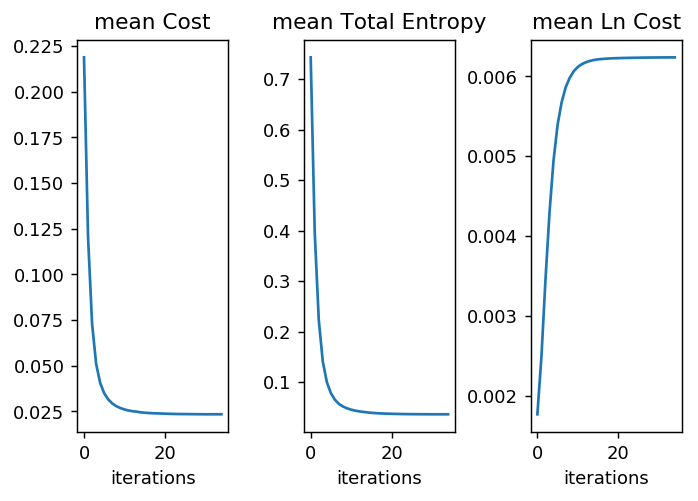

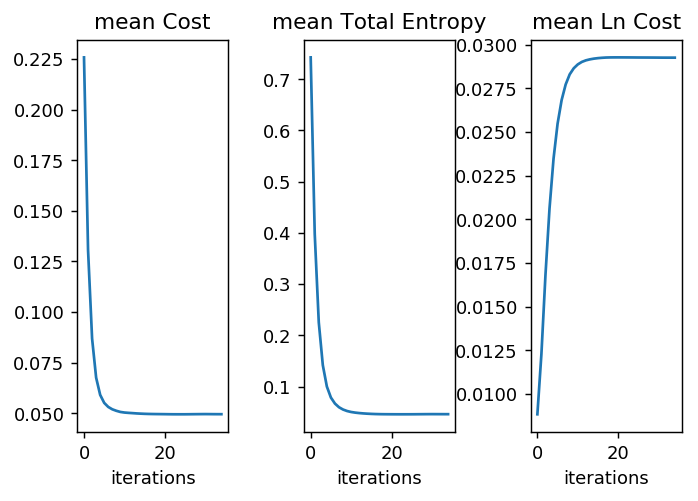

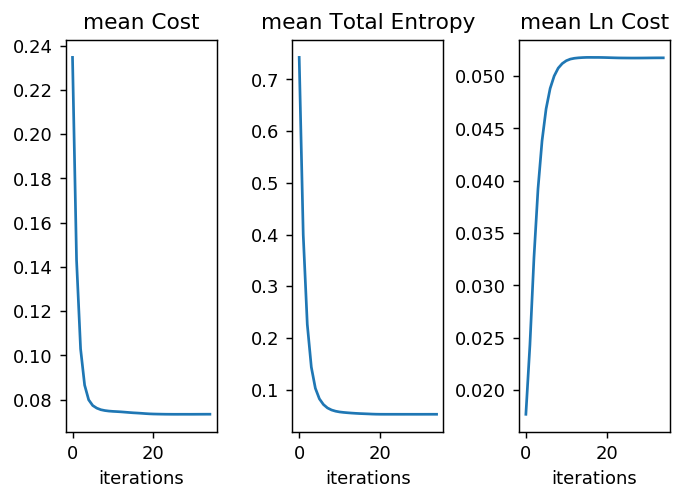

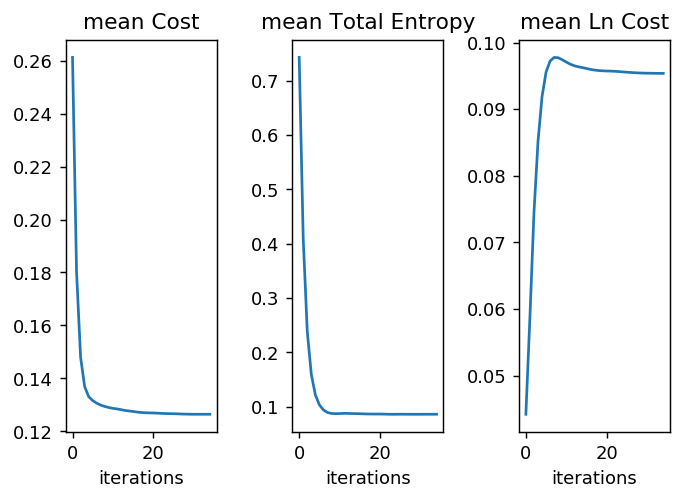

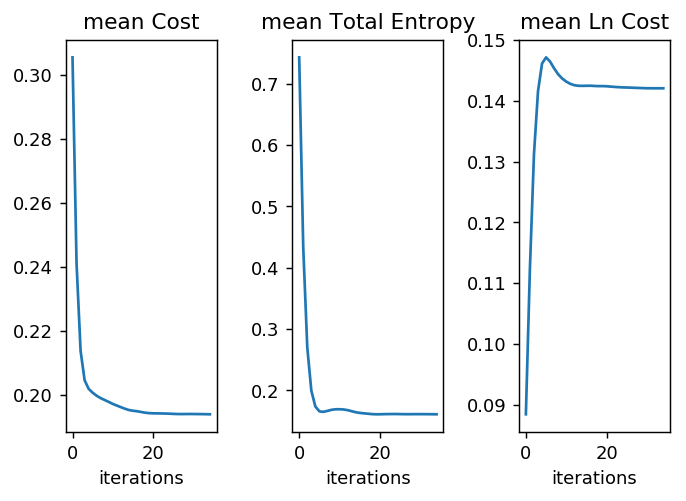

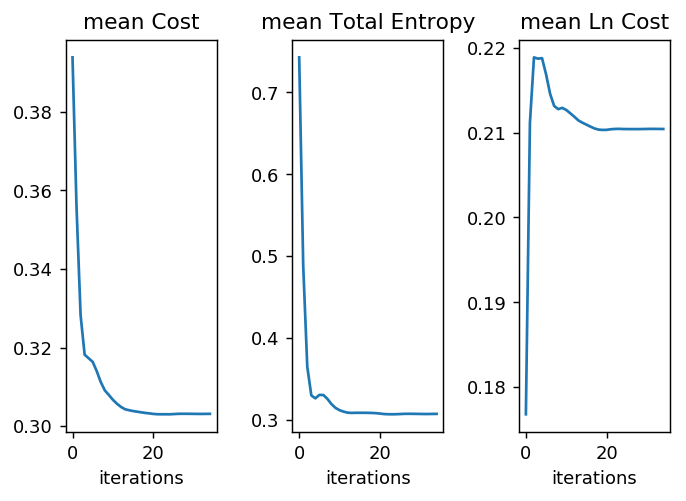

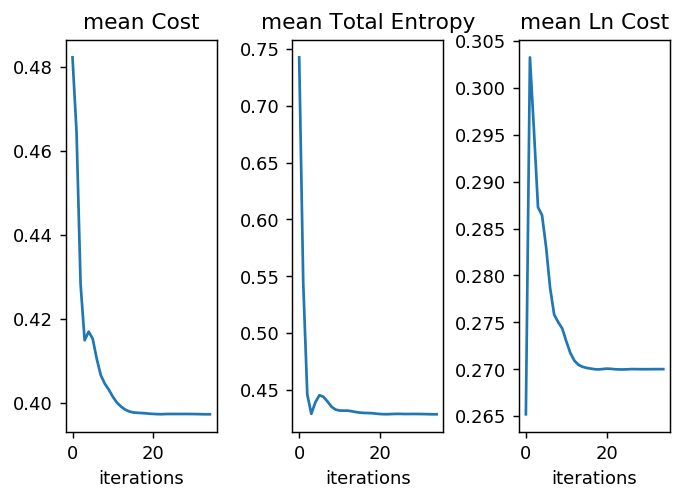

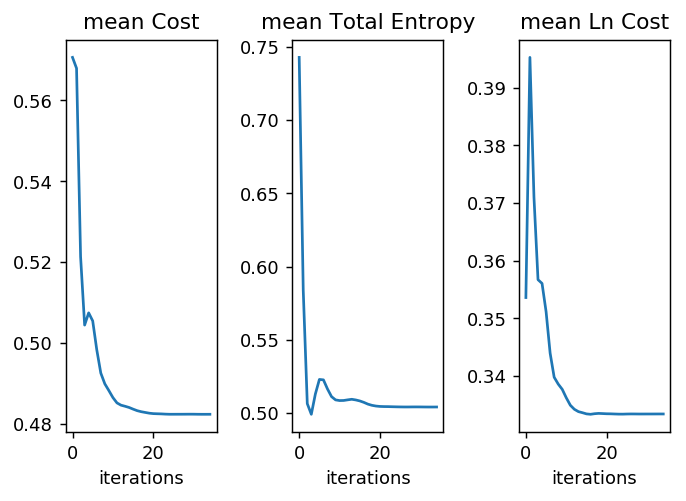

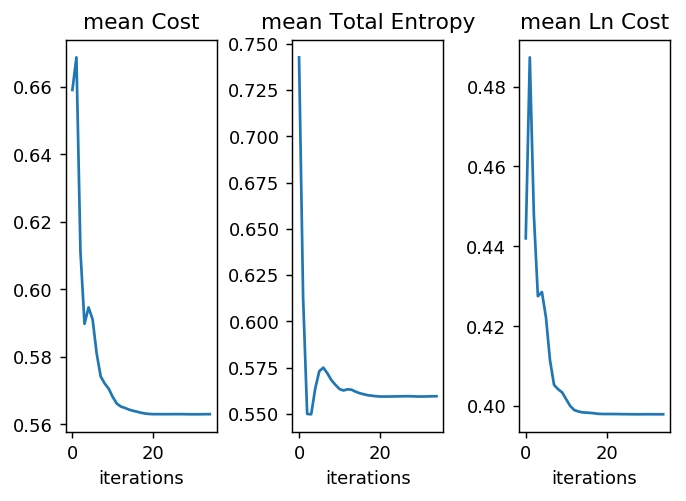

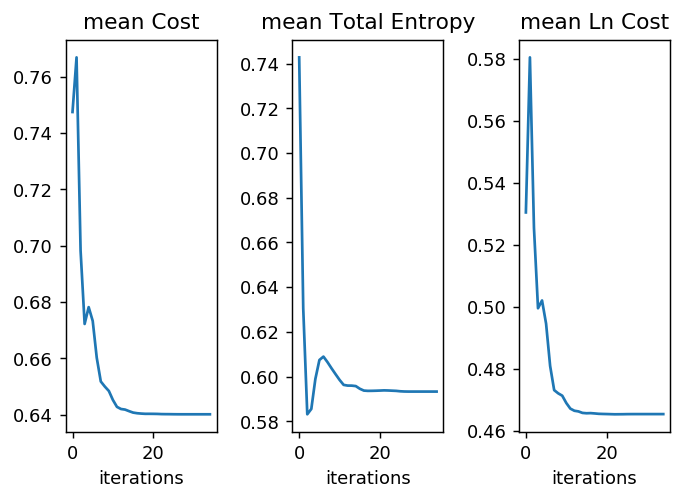

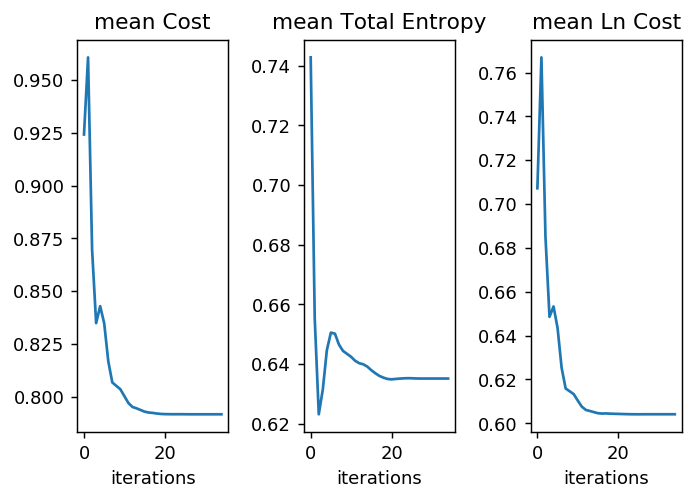

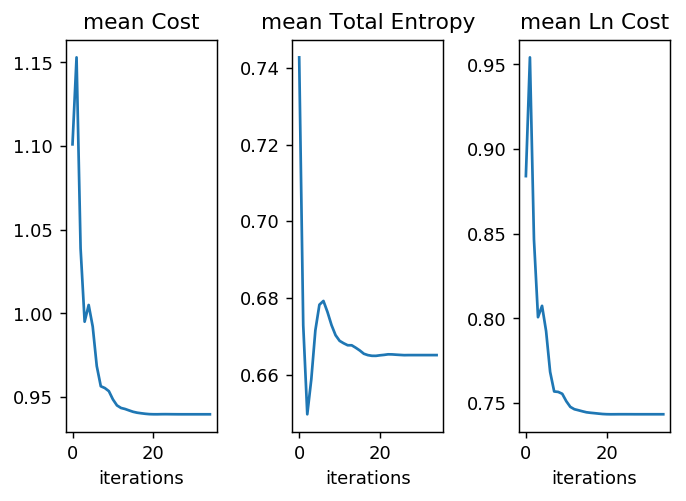

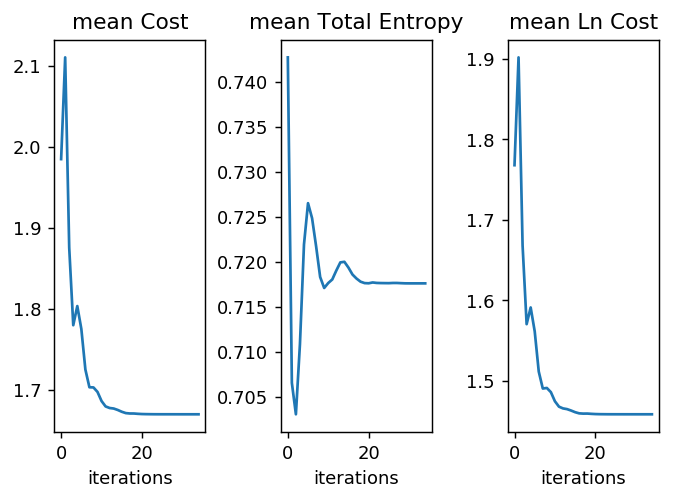

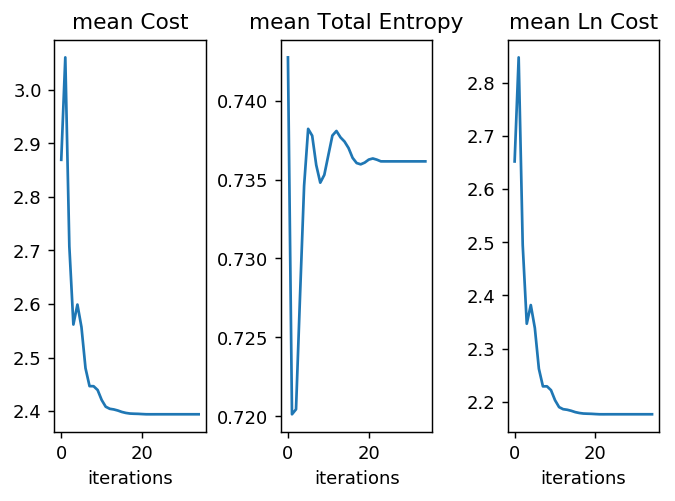

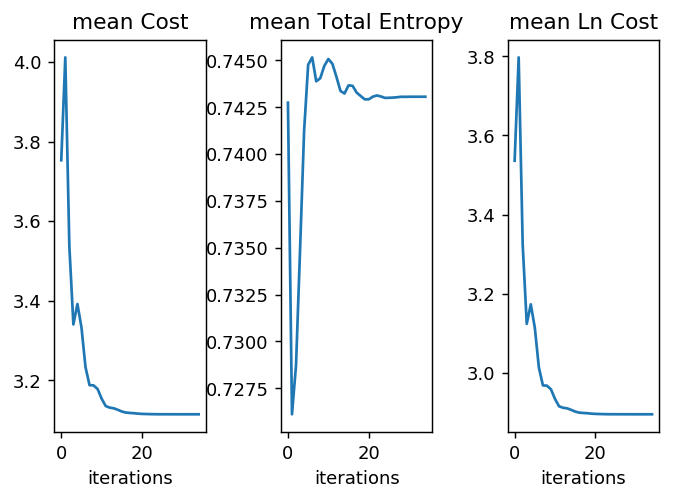

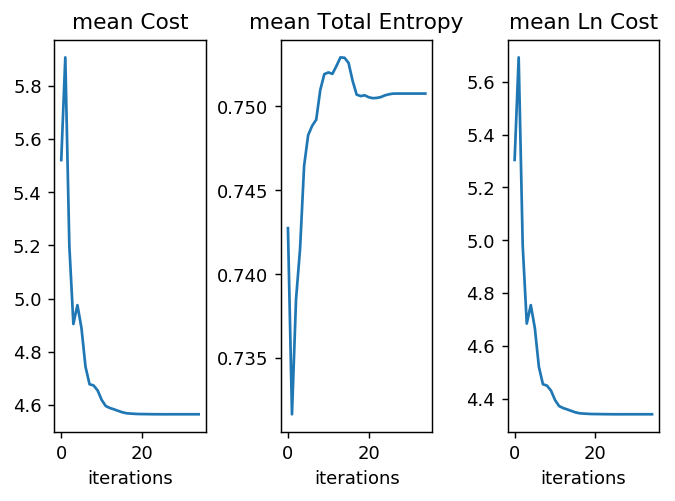

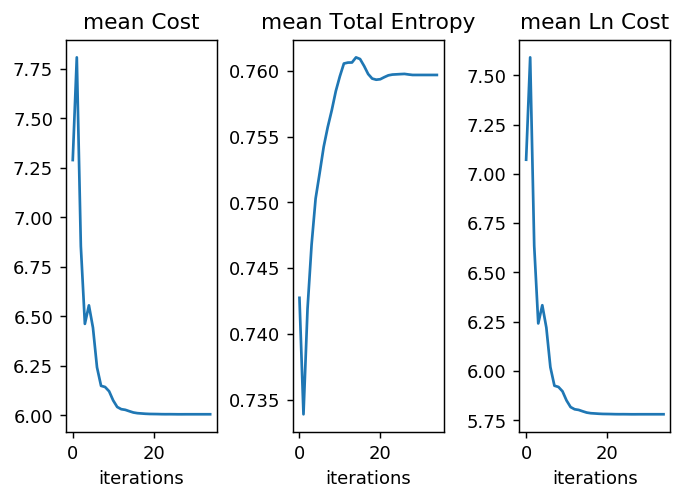

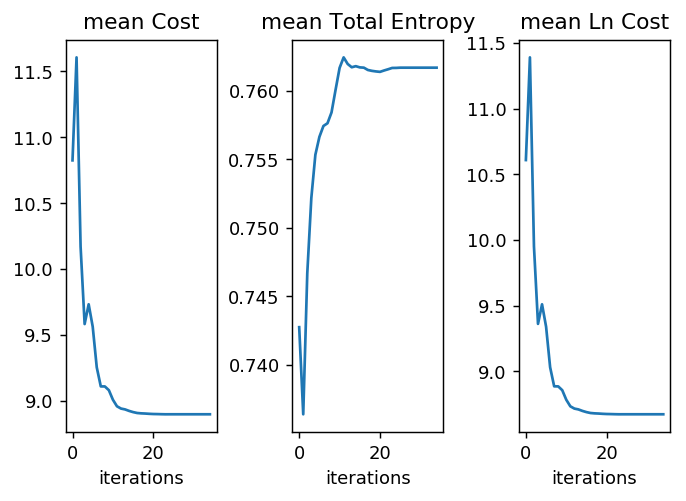

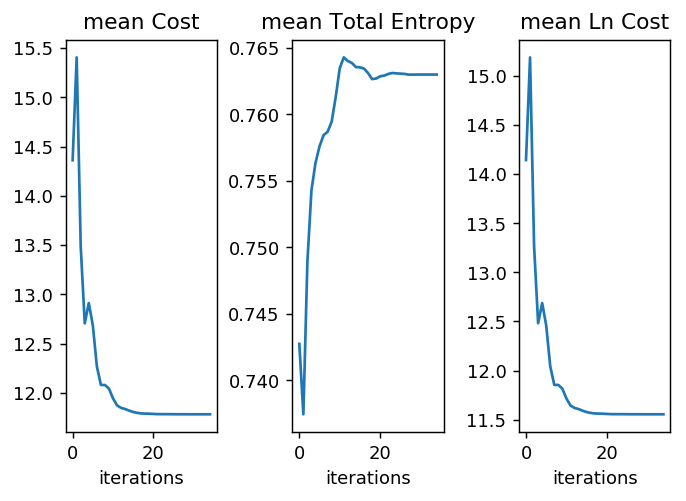

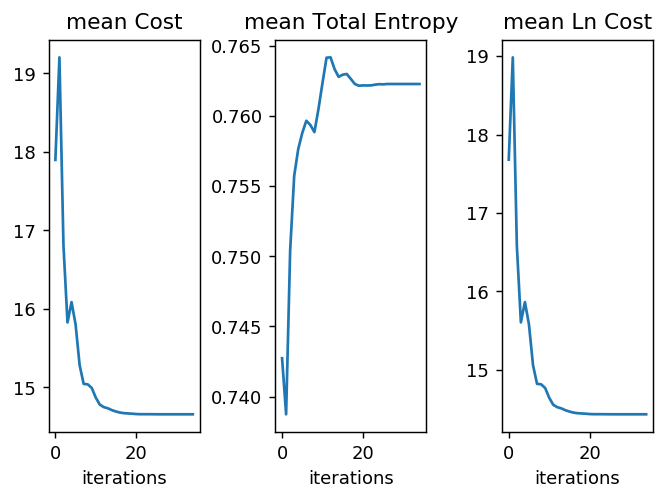

In [26]:
from interpret.CLUE import CLUE
from src.utils import Ln_distance
from src.probability import decompose_std_gauss, decompose_entropy_cat
from interpret.functionally_grounded import get_VAEAC_px, get_VAEAC_px_gauss_cat

batch_size = 1024

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch_e.reshape(x_init_batch_e.shape[0], -1).shape[1]


CLUE_epistemic_delta_err_vec = []
CLUE_epistemic_delta_X_vec = []
CLUE_epistemic_logpx_vec = []

for distance_weight in (CLUE_lambdas / x_dim):

    prediction_similarity_weight = 0

    lr = CLUE_lr_e

    aleatoric_weight = 0
    epistemic_weight = 1
    uncertainty_weight = 0


    torch.autograd.set_detect_anomaly(False)

    x_vec, z_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec = \
    CLUE.batch_optimise(VAE_art, art_BNN, x_init_batch_e, uncertainty_weight=uncertainty_weight, aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,
                          prior_weight=0, distance_weight=distance_weight, desired_preds=None,
                     latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,
                     lr=lr,  cond_mask=None, distance_metric=dist, z_init=z_init_batch_e, norm_MNIST=True,
                          flatten_BNN=True,
                     regression=False, cuda=True, batch_size=batch_size, min_steps=3, max_steps=35, n_early_stop=3)

    fig, axes = plt.subplots(1, 3, dpi=130)
    axes[0].plot(cost_vec.mean(axis=1))
    axes[0].set_title('mean Cost')
    axes[0].set_xlabel('iterations')

    axes[1].plot(uncertainty_vec.mean(axis=1))
    axes[1].set_title('mean Total Entropy')
    axes[1].set_xlabel('iterations')

    axes[2].plot(dist_vec.mean(axis=1))
    axes[2].set_title('mean Ln Cost')
    axes[2].set_xlabel('iterations')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    x_CLUE_epistemic = x_vec[-1]

    ####################################################################
    
    from interpret.functionally_grounded import evaluate_epistemic_explanation_MNIST

    total_uncert_BNN_CLUE_epistemic, aleatoric_uncert_BNN_CLUE_epistemic, epistemic_uncert_BNN_CLUE_epistemic\
            = get_BNN_uncertainties(art_BNN, torch.from_numpy(x_CLUE_epistemic),
                                       regression=False, batch_size=1024,
                                       norm_MNIST=True, flatten=True, return_probs=False, prob_BNN=True)


    CLUE_test_err, CLUE_loglike_vec = evaluate_epistemic_explanation_MNIST(art_BNN, VAEAC,
                                                     torch.Tensor(x_CLUE_epistemic).cuda(),
                                                     test_dims=test_dims, outer_batch_size=512,
                                                     inner_batch_size=512, VAEAC_samples=100)


    # np.save(experiment_dir+'OG_BNN_epistemic_entropy.npy', OG_BNN_epistemic_entropy.data.cpu().numpy())
    # print('baseline BNN epistemic entropy', OG_BNN_epistemic_entropy.mean())


    # base_all_abs_error = base_all_abs_error.cpu().numpy()
    # print(GT_loglike_vec.shape)
    # np.save(experiment_dir+'baseline_BNN_epistemic_loglikes.npy', GT_loglike_vec)
    # print('baseline mean BNN loglike', GT_loglike_vec.mean())
    print('CLUE_epistemic mean BNN epistemic', epistemic_stack.data.cpu().numpy()[epistemic_idxs].mean(), epistemic_uncert_BNN_CLUE_epistemic.mean())

    print('CLUE_epistemic mean BNN error', GT_test_err, CLUE_test_err)
    print('CLUE_epistemic mean BNN loglike', CLUE_loglike_vec.mean())

    CLUE_epistemic_deltax = np.abs(x_art_test[epistemic_idxs] - x_CLUE_epistemic).sum(axis=(1,2,3))
    CLUE_epistemic_fm = (GT_test_err -  CLUE_test_err) / (CLUE_epistemic_deltax + 1e-6)
    print('test sCLUE epistemic fm mean std (epistemic)', np.nanmean(CLUE_epistemic_fm), np.nanstd(CLUE_epistemic_fm))

     ####################################################################
        
    x_to_log_px = binarize_noise(torch.from_numpy(x_CLUE_epistemic), std=0).view(x_CLUE_epistemic.shape[0], -1)
    log_px_vaeac_CLUE_epistemic = get_VAEAC_px(under_VAEAC, x_to_log_px, y_dims=test_dims,
                                               Nsamples=500, bern=True, batch_size=1250).data.cpu().numpy()

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('CLUE_aleatoric log_px [mean, std]', log_px_vaeac_e.mean(), log_px_vaeac_CLUE_epistemic.mean(), log_px_vaeac_CLUE_epistemic.std())

    CLUE_epistemic_delta_err_vec.append((GT_test_err - CLUE_test_err))
    CLUE_epistemic_delta_X_vec.append(CLUE_epistemic_deltax)
    CLUE_epistemic_logpx_vec.append(log_px_vaeac_CLUE_epistemic)
    
CLUE_epistemic_delta_err_vec = np.stack(CLUE_epistemic_delta_err_vec, axis=0)
CLUE_epistemic_delta_X_vec = np.stack(CLUE_epistemic_delta_X_vec, axis=0)
CLUE_epistemic_logpx_vec = np.stack(CLUE_epistemic_logpx_vec, axis=0)


## U-FIDO

In [30]:
torch.cuda.empty_cache()

### Run FIDO aleatoric

In [31]:
fido_lambdas = np.logspace(np.log(0.001), np.log(8000), 30, base=np.e)


In [32]:
from interpret.FIDO import mask_explainer


FIDO_aleatoric_delta_H_vec = []
FIDO_aleatoric_delta_X_vec = []
FIDO_aleatoric_logpx_vec = []
# L1w = FIDO_L1w_dict_a[dname]
for L1w in fido_lambdas:

    FIDO_explanations = []
    FIDO_masks = []

    batch_size = 1024
    x_size = 784
    # L1w = 1000/x_size

    aleatoric_coeff = 1
    epistemic_coeff = 0

    aux_loader = generate_ind_batch(x_init_batch_a.shape[0], batch_size, random=False, roundup=True)
    for idxs in aux_loader: 

        explainer, loss_vec, aleatoric_vec, epistemic_vec = \
            mask_explainer.train_mask(torch.Tensor(x_init_batch_a[idxs]).cuda(), art_BNN, VAEAC_art,
                                      aleatoric_coeff=aleatoric_coeff, epistemic_coeff=epistemic_coeff,
                                      L1w=L1w, N_epochs=30,
                                      mask_samples=20, mask_samples2=10, flatten_ims=True, test_dims=None,
                                      cat=True)

        explanation, mask = explainer.mask_inpaint(torch.Tensor(x_init_batch_a[idxs]).cuda(), VAEAC_art,
                                                   flatten_ims=True, test_dims=None, cat=True)


        FIDO_explanations.append(explanation)
        FIDO_masks.append(mask)

    FIDO_explanations = torch.cat(FIDO_explanations, dim=0).data.cpu()
    FIDO_masks = torch.cat(FIDO_masks, dim=0).data.cpu()

    explainer = None
    torch.cuda.empty_cache()

    x_FIDO_aleatoric  = FIDO_explanations.numpy()
    
    ####################################################
    from interpret.functionally_grounded import get_BNN_uncertainties, evaluate_aleatoric_explanation_cat, evaluate_aleatoric_explanation_gauss

    total_uncert_BNN_FIDO_aleatoric, aleatoric_uncert_BNN_FIDO_aleatoric, epistemic_uncert_BNN_FIDO_aleatoric\
            = get_BNN_uncertainties(art_BNN, torch.from_numpy(x_FIDO_aleatoric),
           regression=False, batch_size=1024,
           norm_MNIST=True, flatten=True, return_probs=False, prob_BNN=True)


    FIDO_VAEAC_aleatoric_uncert = evaluate_aleatoric_explanation_MNIST(VAEAC, torch.Tensor(x_FIDO_aleatoric),
                                                              test_dims,
                                                              N_target_samples=100, batch_size=256)


    print(FIDO_VAEAC_aleatoric_uncert.shape)
    # np.save(experiment_dir+'baseline_BNN_aleatoric_std.npy', OG_BNN_aleatoric_std.data.cpu().numpy())
    print('FIDO_aleatoric BNN aleatoric uncert', aleatoric_stack.data.cpu().numpy()[aleatoric_idxs].mean(axis=0),
          aleatoric_uncert_BNN_FIDO_aleatoric.data.cpu().numpy().mean(axis=0))


    print('test FIDO_aleatoric marginal shape', FIDO_VAEAC_aleatoric_uncert.shape)
    print('test FIDO_aleatoric mean uncert (aleatoric)', OG_VAEAC_aleatoric_uncert.mean(), FIDO_VAEAC_aleatoric_uncert.mean())

    FIDO_aleatoric_deltax = np.abs(x_art_test[aleatoric_idxs] - x_FIDO_aleatoric.reshape(x_FIDO_aleatoric.shape[0], 1, 28, 28)).sum(axis=(1,2,3))
    FIDO_aleatoric_deltaH = (OG_VAEAC_aleatoric_uncert - FIDO_VAEAC_aleatoric_uncert).data.cpu().numpy()
    FIDO_aleatoric_fm = (OG_VAEAC_aleatoric_uncert - FIDO_VAEAC_aleatoric_uncert).data.cpu().numpy() / (FIDO_aleatoric_deltax + 1e-6)
    print('test FIDO aleatoric fm mean std (aleatoric)', np.nanmean(FIDO_aleatoric_fm), np.nanstd(FIDO_aleatoric_fm))
    
    #####################################################

    from interpret.functionally_grounded import get_VAEAC_px, get_VAEAC_px_gauss_cat


    x_to_log_px = binarize_noise(torch.from_numpy(x_FIDO_aleatoric), std=0).view(x_FIDO_aleatoric.shape[0], -1)
    log_px_vaeac_FIDO_aleatoric = get_VAEAC_px(under_VAEAC, x_to_log_px, y_dims=test_dims,
                                               Nsamples=500, bern=True, batch_size=1250).data.cpu().numpy()

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('FIDO_aleatoric log_px [mean, std]', log_px_vaeac_a.mean(), log_px_vaeac_FIDO_aleatoric.mean(), log_px_vaeac_FIDO_aleatoric.std())

    FIDO_aleatoric_delta_H_vec.append(FIDO_aleatoric_deltaH)
    FIDO_aleatoric_delta_X_vec.append(FIDO_aleatoric_deltax)
    FIDO_aleatoric_logpx_vec.append(log_px_vaeac_FIDO_aleatoric)
    
FIDO_aleatoric_delta_H_vec = np.stack(FIDO_aleatoric_delta_H_vec, axis=0)
FIDO_aleatoric_delta_X_vec = np.stack(FIDO_aleatoric_delta_X_vec, axis=0)
FIDO_aleatoric_logpx_vec = np.stack(FIDO_aleatoric_logpx_vec, axis=0)



Net:
it: 0, loss: 0.467, aleatoric: 0.467, epistemic: 0.200
it: 1, loss: 0.453, aleatoric: 0.453, epistemic: 0.194
it: 2, loss: 0.442, aleatoric: 0.441, epistemic: 0.189
it: 3, loss: 0.428, aleatoric: 0.428, epistemic: 0.184
it: 4, loss: 0.417, aleatoric: 0.416, epistemic: 0.179
it: 5, loss: 0.404, aleatoric: 0.404, epistemic: 0.174
it: 6, loss: 0.394, aleatoric: 0.394, epistemic: 0.170
it: 7, loss: 0.385, aleatoric: 0.385, epistemic: 0.166
it: 8, loss: 0.375, aleatoric: 0.375, epistemic: 0.162
it: 9, loss: 0.365, aleatoric: 0.365, epistemic: 0.158
it: 10, loss: 0.355, aleatoric: 0.355, epistemic: 0.154
it: 11, loss: 0.348, aleatoric: 0.347, epistemic: 0.151
it: 12, loss: 0.340, aleatoric: 0.340, epistemic: 0.148
it: 13, loss: 0.333, aleatoric: 0.333, epistemic: 0.145
it: 14, loss: 0.329, aleatoric: 0.329, epistemic: 0.143
it: 15, loss: 0.327, aleatoric: 0.327, epistemic: 0.142
it: 16, loss: 0.326, aleatoric: 0.326, epistemic: 0.142
it: 17, loss: 0.325, aleatoric: 0.325, epistemic: 0.

it: 13, loss: 0.354, aleatoric: 0.342, epistemic: 0.149
it: 14, loss: 0.349, aleatoric: 0.339, epistemic: 0.148
it: 15, loss: 0.347, aleatoric: 0.337, epistemic: 0.147
it: 16, loss: 0.346, aleatoric: 0.336, epistemic: 0.147
it: 17, loss: 0.345, aleatoric: 0.335, epistemic: 0.146
it: 18, loss: 0.345, aleatoric: 0.335, epistemic: 0.146
it: 19, loss: 0.345, aleatoric: 0.335, epistemic: 0.146
it: 20, loss: 0.344, aleatoric: 0.334, epistemic: 0.146
it: 21, loss: 0.344, aleatoric: 0.334, epistemic: 0.146
it: 22, loss: 0.344, aleatoric: 0.334, epistemic: 0.146
it: 23, loss: 0.344, aleatoric: 0.334, epistemic: 0.146
it: 24, loss: 0.344, aleatoric: 0.334, epistemic: 0.146
it: 25, loss: 0.344, aleatoric: 0.334, epistemic: 0.146
it: 26, loss: 0.344, aleatoric: 0.334, epistemic: 0.146
it: 27, loss: 0.343, aleatoric: 0.333, epistemic: 0.146
it: 28, loss: 0.343, aleatoric: 0.333, epistemic: 0.145
it: 29, loss: 0.343, aleatoric: 0.333, epistemic: 0.145

Net:
it: 0, loss: 0.539, aleatoric: 0.489, epis

it: 26, loss: 0.458, aleatoric: 0.416, epistemic: 0.184
it: 27, loss: 0.458, aleatoric: 0.416, epistemic: 0.184
it: 28, loss: 0.458, aleatoric: 0.416, epistemic: 0.185
it: 29, loss: 0.458, aleatoric: 0.416, epistemic: 0.184

Net:
it: 0, loss: 2.990, aleatoric: 0.489, epistemic: 0.211
it: 1, loss: 2.738, aleatoric: 0.484, epistemic: 0.209
it: 2, loss: 2.503, aleatoric: 0.479, epistemic: 0.208
it: 3, loss: 2.272, aleatoric: 0.474, epistemic: 0.207
it: 4, loss: 2.045, aleatoric: 0.470, epistemic: 0.206
it: 5, loss: 1.821, aleatoric: 0.465, epistemic: 0.204
it: 6, loss: 1.641, aleatoric: 0.461, epistemic: 0.203
it: 7, loss: 1.464, aleatoric: 0.458, epistemic: 0.202
it: 8, loss: 1.289, aleatoric: 0.455, epistemic: 0.201
it: 9, loss: 1.116, aleatoric: 0.451, epistemic: 0.200
it: 10, loss: 0.942, aleatoric: 0.447, epistemic: 0.199
it: 11, loss: 0.808, aleatoric: 0.444, epistemic: 0.198
it: 12, loss: 0.680, aleatoric: 0.442, epistemic: 0.197
it: 13, loss: 0.572, aleatoric: 0.439, epistemic: 0.

it: 9, loss: 6.817, aleatoric: 0.493, epistemic: 0.219
it: 10, loss: 5.107, aleatoric: 0.493, epistemic: 0.220
it: 11, loss: 3.764, aleatoric: 0.493, epistemic: 0.220
it: 12, loss: 2.484, aleatoric: 0.493, epistemic: 0.220
it: 13, loss: 1.425, aleatoric: 0.493, epistemic: 0.221
it: 14, loss: 0.813, aleatoric: 0.493, epistemic: 0.221
it: 15, loss: 0.584, aleatoric: 0.493, epistemic: 0.221
it: 16, loss: 0.524, aleatoric: 0.493, epistemic: 0.221
it: 17, loss: 0.503, aleatoric: 0.493, epistemic: 0.221
it: 18, loss: 0.497, aleatoric: 0.493, epistemic: 0.221
it: 19, loss: 0.495, aleatoric: 0.493, epistemic: 0.221
it: 20, loss: 0.494, aleatoric: 0.493, epistemic: 0.221
it: 21, loss: 0.494, aleatoric: 0.493, epistemic: 0.221
it: 22, loss: 0.494, aleatoric: 0.493, epistemic: 0.221
it: 23, loss: 0.494, aleatoric: 0.493, epistemic: 0.221
it: 24, loss: 0.494, aleatoric: 0.493, epistemic: 0.221
it: 25, loss: 0.494, aleatoric: 0.493, epistemic: 0.221
it: 26, loss: 0.494, aleatoric: 0.493, epistemic:

it: 21, loss: 0.495, aleatoric: 0.494, epistemic: 0.221
it: 22, loss: 0.494, aleatoric: 0.494, epistemic: 0.221
it: 23, loss: 0.494, aleatoric: 0.494, epistemic: 0.221
it: 24, loss: 0.494, aleatoric: 0.494, epistemic: 0.221
it: 25, loss: 0.494, aleatoric: 0.494, epistemic: 0.221
it: 26, loss: 0.494, aleatoric: 0.494, epistemic: 0.221
it: 27, loss: 0.494, aleatoric: 0.494, epistemic: 0.221
it: 28, loss: 0.494, aleatoric: 0.494, epistemic: 0.221
it: 29, loss: 0.494, aleatoric: 0.494, epistemic: 0.221
torch.Size([1732])
('FIDO_aleatoric BNN aleatoric uncert', 0.48261982, 0.48261985)
('test FIDO_aleatoric marginal shape', torch.Size([1732]))
('test FIDO_aleatoric mean uncert (aleatoric)', tensor(0.3941), tensor(0.3951))
('test FIDO aleatoric fm mean std (aleatoric)', -1019.29736, 42901.316)
('FIDO_aleatoric log_px [mean, std]', -88.09398, -88.00785, 18.435452)

Net:
it: 0, loss: 500.362, aleatoric: 0.467, epistemic: 0.200
it: 1, loss: 450.569, aleatoric: 0.468, epistemic: 0.201
it: 2, loss

('FIDO_aleatoric log_px [mean, std]', -88.09398, -87.86514, 18.427017)

Net:
it: 0, loss: 1000.254, aleatoric: 0.467, epistemic: 0.200
it: 1, loss: 900.673, aleatoric: 0.468, epistemic: 0.201
it: 2, loss: 806.921, aleatoric: 0.469, epistemic: 0.202
it: 3, loss: 714.972, aleatoric: 0.470, epistemic: 0.203
it: 4, loss: 624.882, aleatoric: 0.471, epistemic: 0.205
it: 5, loss: 534.718, aleatoric: 0.471, epistemic: 0.206
it: 6, loss: 463.383, aleatoric: 0.472, epistemic: 0.206
it: 7, loss: 393.364, aleatoric: 0.472, epistemic: 0.207
it: 8, loss: 322.834, aleatoric: 0.473, epistemic: 0.208
it: 9, loss: 253.844, aleatoric: 0.473, epistemic: 0.208
it: 10, loss: 185.219, aleatoric: 0.474, epistemic: 0.209
it: 11, loss: 131.408, aleatoric: 0.474, epistemic: 0.210
it: 12, loss: 80.263, aleatoric: 0.474, epistemic: 0.210
it: 13, loss: 37.504, aleatoric: 0.475, epistemic: 0.211
it: 14, loss: 13.280, aleatoric: 0.475, epistemic: 0.211
it: 15, loss: 4.094, aleatoric: 0.475, epistemic: 0.211
it: 16, l

it: 9, loss: 1012.982, aleatoric: 0.474, epistemic: 0.209
it: 10, loss: 738.872, aleatoric: 0.474, epistemic: 0.209
it: 11, loss: 524.377, aleatoric: 0.474, epistemic: 0.210
it: 12, loss: 321.127, aleatoric: 0.474, epistemic: 0.210
it: 13, loss: 149.282, aleatoric: 0.475, epistemic: 0.211
it: 14, loss: 51.438, aleatoric: 0.475, epistemic: 0.211
it: 15, loss: 14.776, aleatoric: 0.475, epistemic: 0.211
it: 16, loss: 5.236, aleatoric: 0.475, epistemic: 0.211
it: 17, loss: 1.969, aleatoric: 0.475, epistemic: 0.211
it: 18, loss: 0.991, aleatoric: 0.475, epistemic: 0.211
it: 19, loss: 0.640, aleatoric: 0.475, epistemic: 0.211
it: 20, loss: 0.528, aleatoric: 0.475, epistemic: 0.211
it: 21, loss: 0.498, aleatoric: 0.475, epistemic: 0.211
it: 22, loss: 0.486, aleatoric: 0.475, epistemic: 0.211
it: 23, loss: 0.478, aleatoric: 0.475, epistemic: 0.211
it: 24, loss: 0.477, aleatoric: 0.475, epistemic: 0.211
it: 25, loss: 0.475, aleatoric: 0.475, epistemic: 0.211
it: 26, loss: 0.476, aleatoric: 0.47

### Run FIDO epistemic 

In [33]:

FIDO_epistemic_delta_err_vec = []
FIDO_epistemic_delta_X_vec = []
FIDO_epistemic_logpx_vec = []
# L1w = FIDO_L1w_dict_a[dname]
for L1w in fido_lambdas:

    FIDO_explanations = []
    FIDO_masks = []

    batch_size = 1024
    x_size = 784
    # L1w = 500/x_size

    aleatoric_coeff = 0
    epistemic_coeff = 1

    aux_loader = generate_ind_batch(x_init_batch_e.shape[0], batch_size, random=False, roundup=True)
    for idxs in aux_loader: 

        explainer, loss_vec, aleatoric_vec, epistemic_vec = \
            mask_explainer.train_mask(torch.Tensor(x_init_batch_e[idxs]).cuda(), art_BNN, VAEAC_art,
                                      aleatoric_coeff=aleatoric_coeff, epistemic_coeff=epistemic_coeff,
                                      L1w=L1w, N_epochs=30,
                                      mask_samples=20, mask_samples2=10, flatten_ims=True, test_dims=None,
                                      cat=True)

        explanation, mask = explainer.mask_inpaint(torch.Tensor(x_init_batch_e[idxs]).cuda(), VAEAC_art,
                                                   flatten_ims=True, test_dims=None, cat=True)


        FIDO_explanations.append(explanation)
        FIDO_masks.append(mask)

    FIDO_explanations = torch.cat(FIDO_explanations, dim=0).data.cpu()
    FIDO_masks = torch.cat(FIDO_masks, dim=0).data.cpu()

    print(FIDO_explanations.shape)

    explainer = None
    torch.cuda.empty_cache()

    x_FIDO_epistemic  = FIDO_explanations.numpy()

    #########################################
    
    from interpret.functionally_grounded import evaluate_epistemic_explanation_cat, evaluate_epistemic_explanation_gauss

    total_uncert_BNN_FIDO_epistemic, aleatoric_uncert_BNN_FIDO_epistemic, epistemic_uncert_BNN_FIDO_epistemic\
            = get_BNN_uncertainties(art_BNN, torch.from_numpy(x_FIDO_epistemic),
           regression=False, batch_size=1024,
           norm_MNIST=True, flatten=True, return_probs=False, prob_BNN=True)


    FIDO_test_err, FIDO_loglike_vec = evaluate_epistemic_explanation_MNIST(art_BNN, VAEAC,
                                                     torch.Tensor(x_FIDO_epistemic).cuda(),
                                                     test_dims=test_dims, outer_batch_size=256,
                                                     inner_batch_size=512, VAEAC_samples=100)



    print('FIDO_epistemic mean BNN epistemic', epistemic_stack.data.cpu().numpy()[epistemic_idxs].mean(),
          epistemic_uncert_BNN_FIDO_epistemic.mean())

    print('FIDO_epistemic mean BNN error', GT_test_err, FIDO_test_err)
    print('FIDO_epistemic mean BNN loglike', FIDO_loglike_vec.mean())

    ########

    FIDO_epistemic_deltax = np.abs(x_art_test[epistemic_idxs] - x_FIDO_epistemic.reshape(x_FIDO_epistemic.shape[0], 1, 28, 28)).sum(axis=(1,2,3))
    FIDO_epistemic_fm = (GT_test_err -  FIDO_test_err) / (FIDO_epistemic_deltax + 1e-6)
    print('test FIDO epistemic fm mean std (epistemic)', np.nanmean(FIDO_epistemic_fm), np.nanstd(FIDO_epistemic_fm))

    
    #######################################
    
    x_to_log_px = binarize_noise(torch.from_numpy(x_FIDO_epistemic), std=0).view(x_FIDO_epistemic.shape[0], -1)
    log_px_vaeac_FIDO_epistemic = get_VAEAC_px(under_VAEAC, x_to_log_px, y_dims=test_dims,
                                               Nsamples=500, bern=True, batch_size=1250).data.cpu().numpy()

    # log_px_vaeac = log_px_vaeac[log_px_vaeac>hard_min_lox_px]

    print('FIDO_epistemic log_px [mean, std]', log_px_vaeac_e.mean(), log_px_vaeac_FIDO_epistemic.mean(), log_px_vaeac_FIDO_epistemic.std())

    
    FIDO_epistemic_delta_err_vec.append((GT_test_err - FIDO_test_err))
    FIDO_epistemic_delta_X_vec.append(FIDO_epistemic_deltax)
    FIDO_epistemic_logpx_vec.append(log_px_vaeac_FIDO_epistemic)
    
FIDO_epistemic_delta_err_vec = np.stack(FIDO_epistemic_delta_err_vec, axis=0)
FIDO_epistemic_delta_X_vec = np.stack(FIDO_epistemic_delta_X_vec, axis=0)
FIDO_epistemic_logpx_vec = np.stack(FIDO_epistemic_logpx_vec, axis=0)



Net:
it: 0, loss: 0.240, aleatoric: 0.542, epistemic: 0.239
it: 1, loss: 0.234, aleatoric: 0.530, epistemic: 0.234
it: 2, loss: 0.229, aleatoric: 0.518, epistemic: 0.229
it: 3, loss: 0.224, aleatoric: 0.506, epistemic: 0.223
it: 4, loss: 0.219, aleatoric: 0.495, epistemic: 0.218
it: 5, loss: 0.214, aleatoric: 0.484, epistemic: 0.213
it: 6, loss: 0.210, aleatoric: 0.475, epistemic: 0.209
it: 7, loss: 0.206, aleatoric: 0.465, epistemic: 0.205
it: 8, loss: 0.201, aleatoric: 0.456, epistemic: 0.201
it: 9, loss: 0.197, aleatoric: 0.446, epistemic: 0.197
it: 10, loss: 0.193, aleatoric: 0.437, epistemic: 0.193
it: 11, loss: 0.190, aleatoric: 0.430, epistemic: 0.190
it: 12, loss: 0.187, aleatoric: 0.422, epistemic: 0.186
it: 13, loss: 0.184, aleatoric: 0.415, epistemic: 0.183
it: 14, loss: 0.182, aleatoric: 0.411, epistemic: 0.182
it: 15, loss: 0.181, aleatoric: 0.409, epistemic: 0.181
it: 16, loss: 0.180, aleatoric: 0.408, epistemic: 0.180
it: 17, loss: 0.180, aleatoric: 0.408, epistemic: 0.

it: 13, loss: 0.200, aleatoric: 0.427, epistemic: 0.189
it: 14, loss: 0.197, aleatoric: 0.424, epistemic: 0.188
it: 15, loss: 0.196, aleatoric: 0.422, epistemic: 0.187
it: 16, loss: 0.195, aleatoric: 0.421, epistemic: 0.187
it: 17, loss: 0.195, aleatoric: 0.421, epistemic: 0.186
it: 18, loss: 0.195, aleatoric: 0.420, epistemic: 0.186
it: 19, loss: 0.195, aleatoric: 0.420, epistemic: 0.186
it: 20, loss: 0.195, aleatoric: 0.420, epistemic: 0.186
it: 21, loss: 0.195, aleatoric: 0.420, epistemic: 0.186
it: 22, loss: 0.195, aleatoric: 0.419, epistemic: 0.186
it: 23, loss: 0.195, aleatoric: 0.419, epistemic: 0.186
it: 24, loss: 0.194, aleatoric: 0.419, epistemic: 0.186
it: 25, loss: 0.194, aleatoric: 0.419, epistemic: 0.186
it: 26, loss: 0.194, aleatoric: 0.419, epistemic: 0.186
it: 27, loss: 0.194, aleatoric: 0.419, epistemic: 0.186
it: 28, loss: 0.194, aleatoric: 0.419, epistemic: 0.186
it: 29, loss: 0.194, aleatoric: 0.419, epistemic: 0.185

Net:
it: 0, loss: 0.296, aleatoric: 0.558, epis

it: 26, loss: 0.252, aleatoric: 0.524, epistemic: 0.238
it: 27, loss: 0.252, aleatoric: 0.524, epistemic: 0.238
it: 28, loss: 0.252, aleatoric: 0.524, epistemic: 0.238
it: 29, loss: 0.252, aleatoric: 0.525, epistemic: 0.238

Net:
it: 0, loss: 2.747, aleatoric: 0.557, epistemic: 0.246
it: 1, loss: 2.498, aleatoric: 0.556, epistemic: 0.246
it: 2, loss: 2.263, aleatoric: 0.555, epistemic: 0.246
it: 3, loss: 2.036, aleatoric: 0.552, epistemic: 0.246
it: 4, loss: 1.811, aleatoric: 0.550, epistemic: 0.246
it: 5, loss: 1.589, aleatoric: 0.549, epistemic: 0.246
it: 6, loss: 1.411, aleatoric: 0.548, epistemic: 0.246
it: 7, loss: 1.236, aleatoric: 0.546, epistemic: 0.246
it: 8, loss: 1.060, aleatoric: 0.544, epistemic: 0.246
it: 9, loss: 0.888, aleatoric: 0.543, epistemic: 0.246
it: 10, loss: 0.717, aleatoric: 0.542, epistemic: 0.246
it: 11, loss: 0.585, aleatoric: 0.540, epistemic: 0.246
it: 12, loss: 0.456, aleatoric: 0.539, epistemic: 0.246
it: 13, loss: 0.350, aleatoric: 0.538, epistemic: 0.

it: 9, loss: 6.584, aleatoric: 0.560, epistemic: 0.255
it: 10, loss: 4.877, aleatoric: 0.560, epistemic: 0.256
it: 11, loss: 3.533, aleatoric: 0.561, epistemic: 0.256
it: 12, loss: 2.254, aleatoric: 0.560, epistemic: 0.257
it: 13, loss: 1.187, aleatoric: 0.561, epistemic: 0.257
it: 14, loss: 0.573, aleatoric: 0.561, epistemic: 0.257
it: 15, loss: 0.346, aleatoric: 0.561, epistemic: 0.257
it: 16, loss: 0.286, aleatoric: 0.561, epistemic: 0.258
it: 17, loss: 0.267, aleatoric: 0.561, epistemic: 0.258
it: 18, loss: 0.260, aleatoric: 0.561, epistemic: 0.258
it: 19, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 20, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 21, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 22, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 23, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 24, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 25, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 26, loss: 0.258, aleatoric: 0.561, epistemic:

it: 21, loss: 0.259, aleatoric: 0.561, epistemic: 0.258
it: 22, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 23, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 24, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 25, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 26, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 27, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 28, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
it: 29, loss: 0.258, aleatoric: 0.561, epistemic: 0.258
torch.Size([1318, 784])
('FIDO_epistemic mean BNN epistemic', 0.25375184, tensor(0.2538, device='cuda:0'))
('FIDO_epistemic mean BNN error', 0.17450682852807284, 0.17602427921092564)
('FIDO_epistemic mean BNN loglike', -0.5229039)
('test FIDO epistemic fm mean std (epistemic)', -1517.4509, 0.00024414062)
('FIDO_epistemic log_px [mean, std]', -89.99248, -89.748695, 18.536581)

Net:
it: 0, loss: 500.275, aleatoric: 0.542, epistemic: 0.239
it: 1, loss: 450.143, aleatoric: 0.543, epistemic: 0.24

('FIDO_epistemic log_px [mean, std]', -89.99248, -89.52327, 18.555351)

Net:
it: 0, loss: 999.957, aleatoric: 0.542, epistemic: 0.239
it: 1, loss: 899.905, aleatoric: 0.544, epistemic: 0.241
it: 2, loss: 806.445, aleatoric: 0.545, epistemic: 0.242
it: 3, loss: 714.570, aleatoric: 0.546, epistemic: 0.244
it: 4, loss: 624.609, aleatoric: 0.547, epistemic: 0.245
it: 5, loss: 534.694, aleatoric: 0.548, epistemic: 0.246
it: 6, loss: 463.115, aleatoric: 0.548, epistemic: 0.247
it: 7, loss: 392.536, aleatoric: 0.549, epistemic: 0.248
it: 8, loss: 322.456, aleatoric: 0.549, epistemic: 0.249
it: 9, loss: 253.312, aleatoric: 0.550, epistemic: 0.250
it: 10, loss: 185.032, aleatoric: 0.550, epistemic: 0.250
it: 11, loss: 130.967, aleatoric: 0.550, epistemic: 0.251
it: 12, loss: 80.193, aleatoric: 0.551, epistemic: 0.252
it: 13, loss: 37.382, aleatoric: 0.551, epistemic: 0.252
it: 14, loss: 12.924, aleatoric: 0.551, epistemic: 0.252
it: 15, loss: 3.823, aleatoric: 0.551, epistemic: 0.253
it: 16, lo

it: 9, loss: 1013.112, aleatoric: 0.550, epistemic: 0.250
it: 10, loss: 738.307, aleatoric: 0.550, epistemic: 0.250
it: 11, loss: 524.499, aleatoric: 0.550, epistemic: 0.251
it: 12, loss: 320.735, aleatoric: 0.551, epistemic: 0.252
it: 13, loss: 148.112, aleatoric: 0.551, epistemic: 0.252
it: 14, loss: 50.717, aleatoric: 0.551, epistemic: 0.252
it: 15, loss: 14.593, aleatoric: 0.551, epistemic: 0.253
it: 16, loss: 5.005, aleatoric: 0.551, epistemic: 0.253
it: 17, loss: 1.773, aleatoric: 0.551, epistemic: 0.253
it: 18, loss: 0.735, aleatoric: 0.551, epistemic: 0.253
it: 19, loss: 0.396, aleatoric: 0.551, epistemic: 0.253
it: 20, loss: 0.301, aleatoric: 0.551, epistemic: 0.253
it: 21, loss: 0.281, aleatoric: 0.551, epistemic: 0.253
it: 22, loss: 0.266, aleatoric: 0.551, epistemic: 0.253
it: 23, loss: 0.257, aleatoric: 0.551, epistemic: 0.253
it: 24, loss: 0.254, aleatoric: 0.551, epistemic: 0.253
it: 25, loss: 0.253, aleatoric: 0.551, epistemic: 0.253
it: 26, loss: 0.253, aleatoric: 0.55

AttributeError: 'list' object has no attribute 'mean'

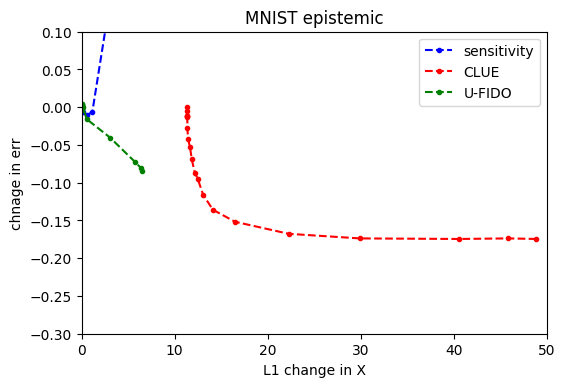

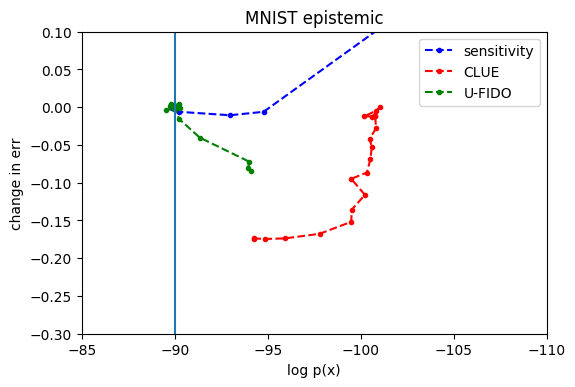

<Figure size 600x400 with 0 Axes>

In [55]:



plt.figure(dpi=100)
plt.plot(sense_epistemic_delta_X_vec.mean(axis=1), -sense_epistemic_delta_err_vec, '--.', c='b')
plt.plot(CLUE_epistemic_delta_X_vec.mean(axis=1), -CLUE_epistemic_delta_err_vec, '--.', c='r')
plt.plot(FIDO_epistemic_delta_X_vec.mean(axis=1), -FIDO_epistemic_delta_err_vec, '--.', c='g')
plt.title(dname + ' epistemic')
plt.legend(['sensitivity', 'CLUE', 'U-FIDO'])
plt.xlabel('L1 change in X')
plt.ylabel('chnage in err')
plt.ylim([-0.3, 0.1])
plt.xlim([0, 50])
# ax = plt.gca()
# ax.invert_xaxis()

plt.figure(dpi=100)
plt.plot(sense_epistemic_logpx_vec.mean(axis=1), -sense_epistemic_delta_err_vec, '--.', c='b')
plt.plot(CLUE_epistemic_logpx_vec.mean(axis=1), -CLUE_epistemic_delta_err_vec, '--.', c='r')
plt.plot(FIDO_epistemic_logpx_vec.mean(axis=1), -FIDO_epistemic_delta_err_vec, '--.', c='g')
ax = plt.gca()
ax.axvline(x=log_px_vaeac_e.mean())
plt.title(dname + ' epistemic')
plt.legend(['sensitivity', 'CLUE', 'U-FIDO'])
plt.xlabel('log p(x)')
plt.ylabel('change in err')
plt.ylim([-0.3, 0.1])
plt.xlim([log_px_vaeac_e.mean().item()-20, log_px_vaeac_e.mean().item()+5])
ax.invert_xaxis()


plt.figure(dpi=100)
plt.plot(sense_aleatoric_delta_X_vec.mean(axis=1), -sense_aleatoric_delta_H_vec.mean(axis=1), '--.', c='b')
plt.plot(CLUE_aleatoric_delta_X_vec.mean(axis=1), -CLUE_aleatoric_delta_H_vec.mean(axis=1), '--.', c='r')
plt.plot(FIDO_aleatoric_delta_X_vec.mean(axis=1), -FIDO_aleatoric_delta_H_vec.mean(axis=1), '--.', c='g')
plt.title(dname + ' Aleatoric')
plt.legend(['sensitivity', 'CLUE', 'U-FIDO'])
plt.xlabel('L1 change in X')
plt.ylabel('change in H')
plt.ylim([-0.5, 0.1])
plt.xlim([0, 50])
# ax = plt.gca()
# ax.invert_xaxis()

plt.figure(dpi=100)
plt.plot(sense_aleatoric_logpx_vec.mean(axis=1), -sense_aleatoric_delta_H_vec.mean(axis=1), '--.', c='b')
plt.plot(CLUE_aleatoric_logpx_vec.mean(axis=1), -CLUE_aleatoric_delta_H_vec.mean(axis=1), '--.', c='r')
plt.plot(FIDO_aleatoric_logpx_vec.mean(axis=1), -FIDO_aleatoric_delta_H_vec.mean(axis=1), '--.', c='g')
ax = plt.gca()
ax.axvline(x=log_px_vaeac_a.mean())

plt.title(dname + ' Aleatoric')
plt.legend(['sensitivity', 'CLUE', 'U-FIDO'])
plt.xlabel('log p(x)')
plt.ylabel('change in H')
plt.xlim([log_px_vaeac_a.mean().item()-20, log_px_vaeac_a.mean().item()+5])
# plt.ylim([-0.1, 0.3])
ax.invert_xaxis()
plt.ylim([-0.5, 0.1])